In [97]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np

db_conn = {
     "user": "root",
     "password": "Dhyoon96!",
     "host": "127.0.0.1",
     "database": "side_proj_FCO"
 }

db_engine = "mysql+pymysql://%s:%s@%s/%s" % (
    db_conn["user"],
    db_conn["password"],
    db_conn["host"],
    db_conn["database"]
)

engine = create_engine(db_engine, echo=True)

In [98]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [99]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [100]:
df_query = 'SELECT * FROM match_user'
df1 = pd.read_sql(df_query, con = engine);

2024-12-31 22:26:52,014 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-12-31 22:26:52,014 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-31 22:26:52,014 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-12-31 22:26:52,020 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-31 22:26:52,022 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-12-31 22:26:52,023 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-31 22:26:52,023 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2024-12-31 22:26:52,023 INFO sqlalchemy.engine.Engine [generated in 0.00112s] {'table_schema': 'side_proj_fco', 'table_name': 'SELECT * FROM match_user'}
2024-12-31 22:26:52,023 INFO sqlalchemy.engine.Engine SELECT * FROM match_user
2024-12-31 22:26:52,023 INFO sqlalchemy.engine.Engine [raw sql] {}


In [103]:
df1['match_result'].value_counts()

match_result
승    497
패    463
무    199
Name: count, dtype: int64

In [104]:
df1['match_endtype'].value_counts() # 0 : 정상 종료, 1 : 몰수승, 2 : 몰수패

match_endtype
0    987
1    100
2     72
Name: count, dtype: int64

In [105]:
df1 = df1[df1['match_endtype'] == 0].reset_index(drop = True) # 정상 종료된 데이터만 사용

In [107]:
df1['match_total_pass_rate'] = (df1['match_total_pass_suc'] / df1['match_total_pass_try']).replace(np.nan, 0)

df1['match_total_pass_short_rate'] = (df1['match_total_pass_short_suc'] / df1['match_total_pass_short_try']).replace(np.nan, 0)
df1['match_total_pass_long_rate'] = (df1['match_total_pass_long_suc'] / df1['match_total_pass_long_try']).replace(np.nan, 0)
df1['match_total_pass_through_rate'] = (df1['match_total_pass_through_suc'] / df1['match_total_pass_through_try']).replace(np.nan, 0)

df1['match_total_shoot_inpenalty_rate'] = (df1['match_total_shoot_inpenalty_suc'] / df1['match_total_shoot_inpenalty_try']).replace(np.nan, 0)
df1['match_total_shoot_outpenalty_rate'] = (df1['match_total_shoot_outpenalty_suc'] / df1['match_total_shoot_outpenalty_try']).replace(np.nan, 0)

df1 = df1.drop(columns = ['match_total_pass_suc', 
                         'match_total_pass_short_suc', 
                         'match_total_pass_long_suc', 
                         'match_total_pass_through_suc', 
                         'match_total_shoot_inpenalty_suc', 
                         'match_total_shoot_outpenalty_suc'])

In [108]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   match_id                           987 non-null    object 
 1   user_ouid                          987 non-null    object 
 2   user_nickname                      987 non-null    object 
 3   match_result                       987 non-null    object 
 4   match_endtype                      987 non-null    int64  
 5   match_possession                   987 non-null    int64  
 6   match_avg_rating                   987 non-null    float64
 7   match_total_dribble                987 non-null    int64  
 8   match_total_pass_try               987 non-null    int64  
 9   match_total_shoot                  987 non-null    int64  
 10  match_total_shoot_eff              987 non-null    int64  
 11  match_total_goal                   987 non-null    int64  

---

# 변수간 상관관계 및 VIF 확인

### 변수간 상관관계 분석 

In [109]:
df1_temp = df1.drop(columns = ['match_id', 'user_ouid', 'user_nickname', 'match_result', 'match_endtype'])

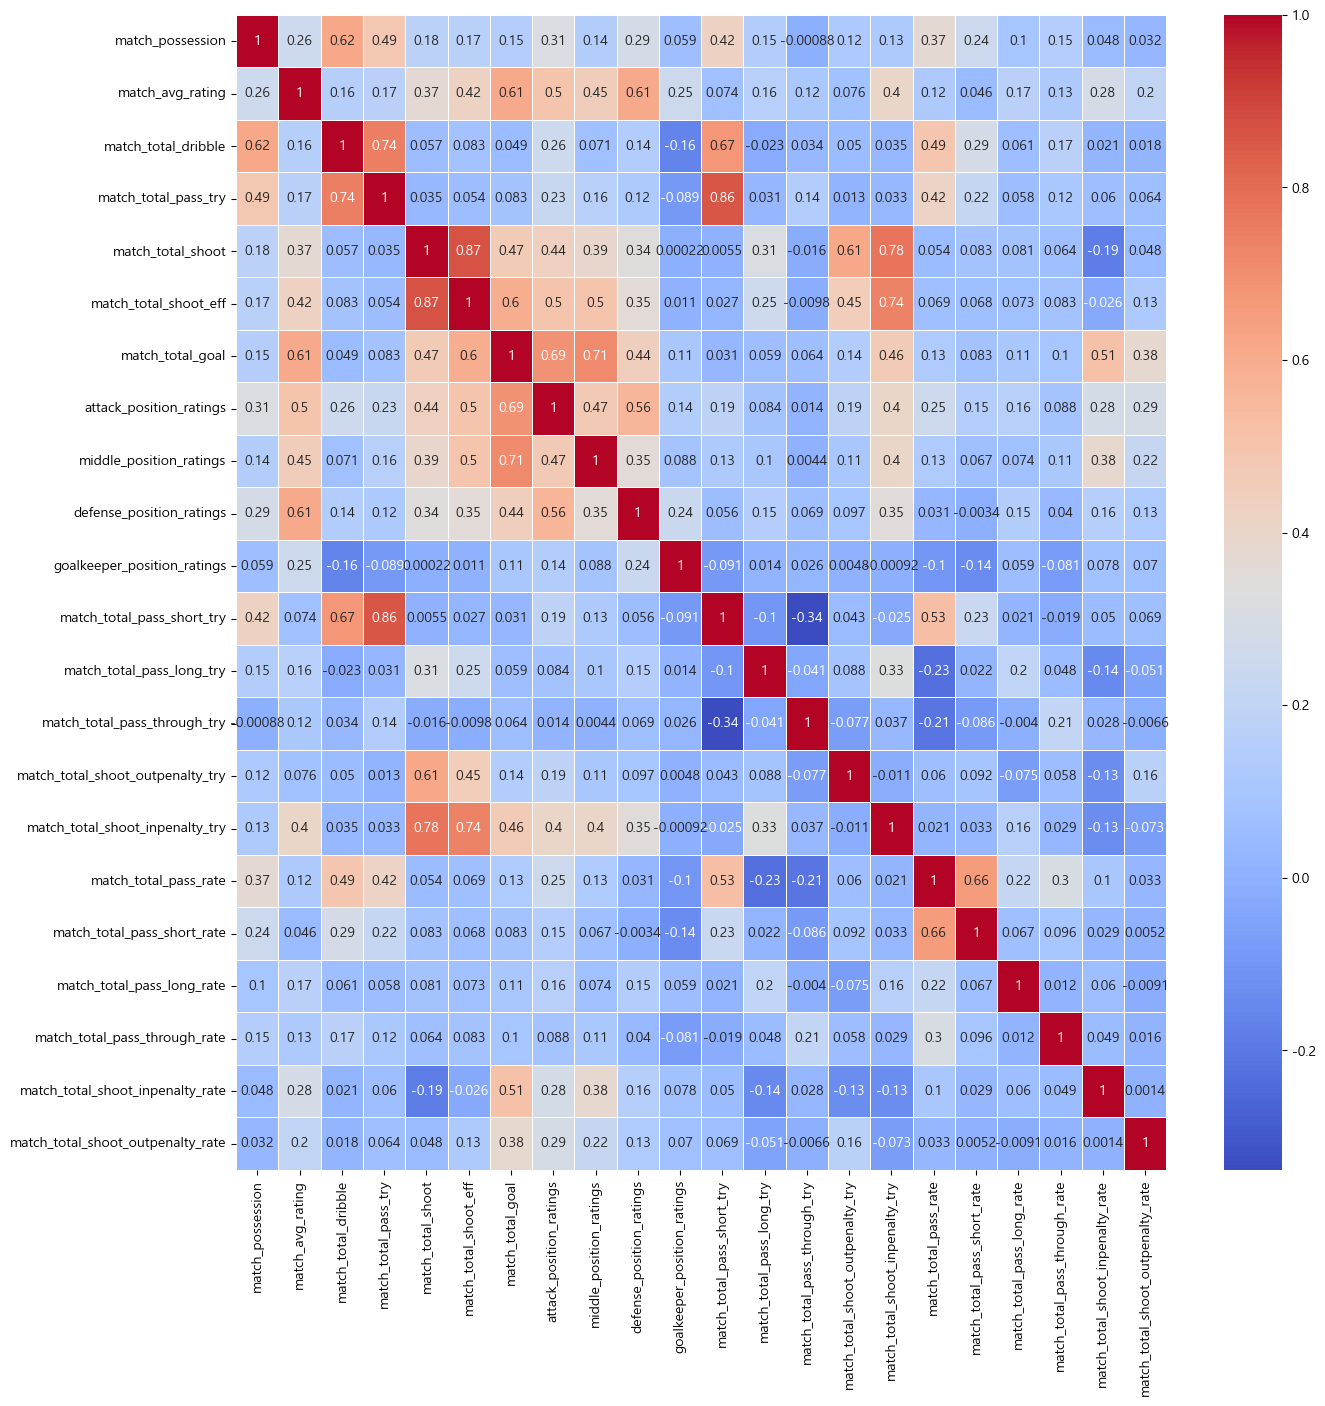

In [111]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(df1_temp.corr(), annot = True, linewidths = .5, cmap = 'coolwarm')
plt.show()

In [280]:
threshold = 0.8
corr_matrix = df1_temp.corr()

strong_corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))    
    .stack()    
    .reset_index()  
)
strong_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Correlation'] > threshold]

print(strong_corr_pairs)

              Variable 1                  Variable 2  Correlation
67  match_total_pass_try  match_total_pass_short_try     0.855697
78     match_total_shoot       match_total_shoot_eff     0.869117


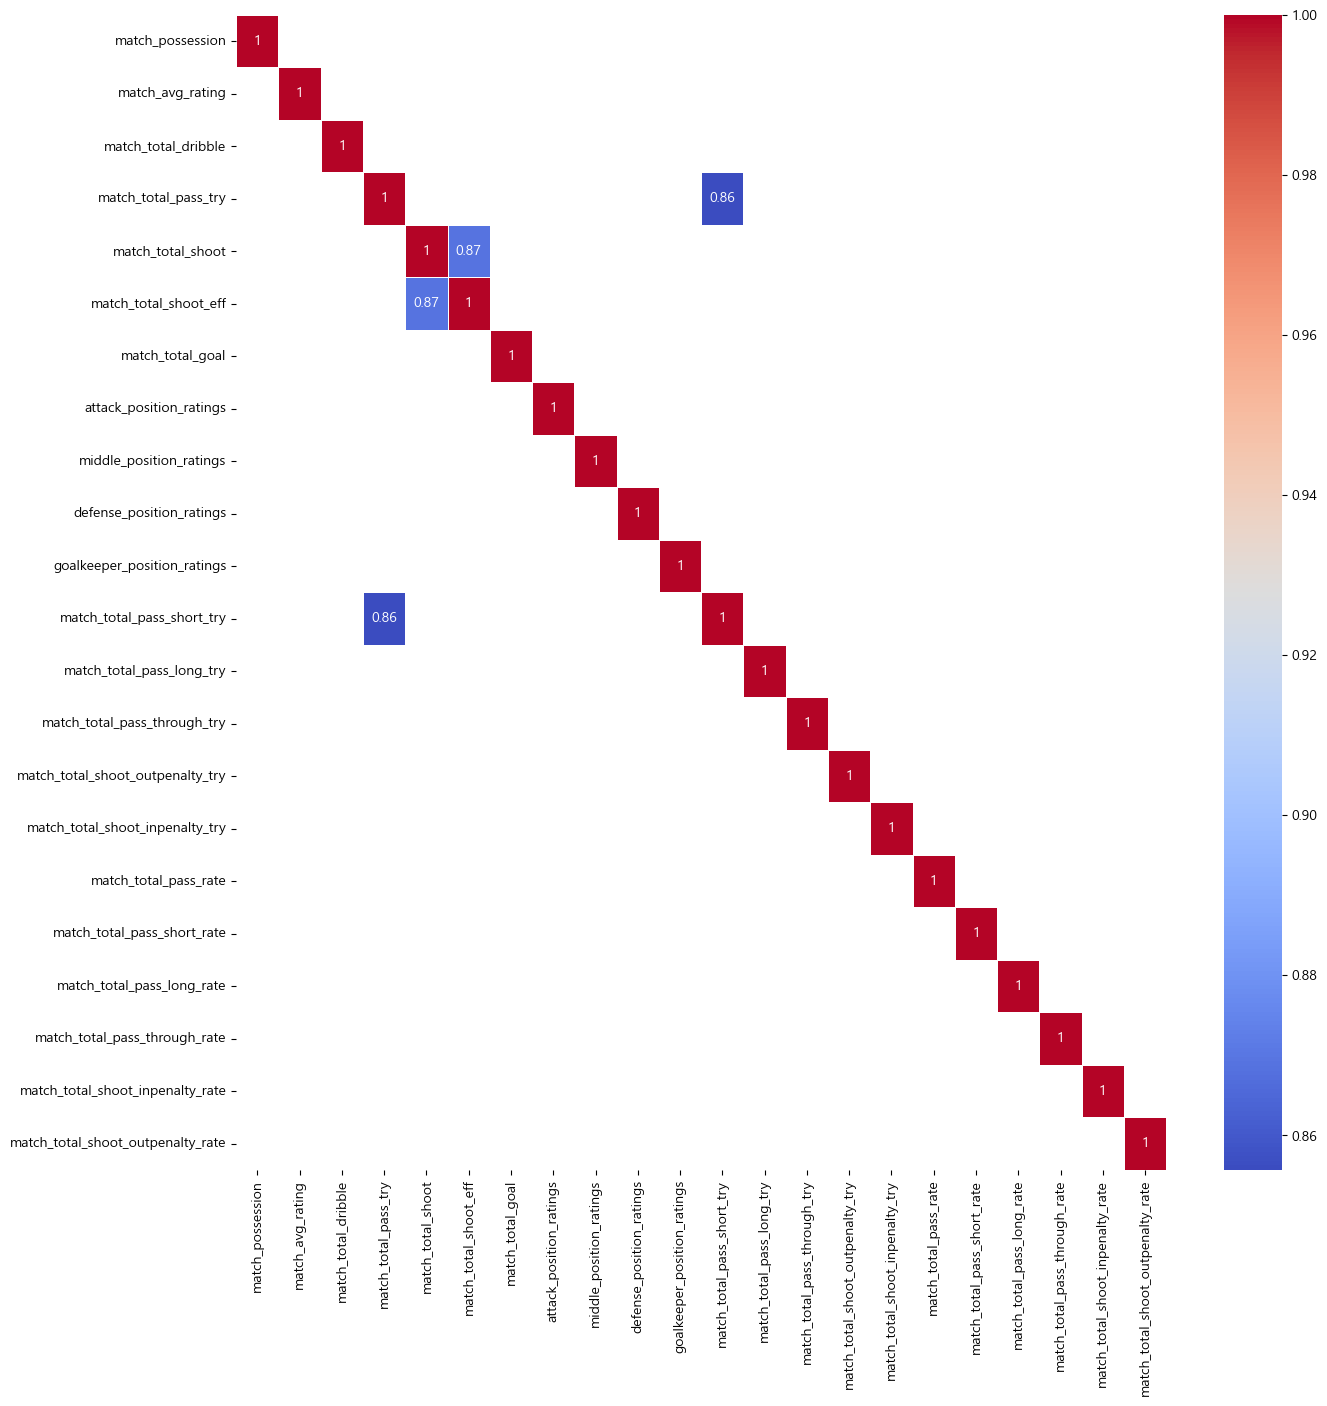

In [281]:
mask = np.abs(corr_matrix) <= threshold  

fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(corr_matrix, mask = mask, annot = True, linewidths = 0.5, cmap = 'coolwarm', ax = ax)
plt.show()

### 변수 제거 후 상관계수 및 VIF 확인

In [203]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Removal Based on VIF Threshold
def calculate_vif_(X, thresh = 10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped = True
    
    while dropped:
        dropped = False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(f"Dropping '{X[cols[variables]].columns[maxloc]}' at index {maxloc}")
            variables = np.delete(variables, maxloc)
            dropped = True

    if len(variables) == 0:
        print("All variables were removed. No remaining variables.")
        return pd.DataFrame() 

    print("Remaining variables:")
    print(X.columns[variables])
    return X[cols[variables]]

df2_temp = calculate_vif_(df1_temp)

# df2_temp = df1_temp.drop(columns = ['match_avg_rating', 
#                           'match_total_dribble', 'match_total_pass_try', 'match_total_pass_suc',
#                           'match_total_shoot', 'match_total_shoot_eff']
#                            + position_ratings_col)

Dropping 'match_total_pass_rate' at index 16
Dropping 'match_total_shoot' at index 4
Dropping 'match_total_pass_try' at index 3
Dropping 'match_total_pass_short_rate' at index 14
Dropping 'defense_position_ratings' at index 7
Dropping 'attack_position_ratings' at index 5
Dropping 'match_avg_rating' at index 1
Dropping 'match_possession' at index 0
Dropping 'middle_position_ratings' at index 3
Dropping 'match_total_dribble' at index 0
Dropping 'match_total_pass_through_rate' at index 9
Dropping 'match_total_shoot_eff' at index 0
Dropping 'goalkeeper_position_ratings' at index 1
Dropping 'match_total_goal' at index 0
Remaining variables:
Index(['match_total_pass_short_try', 'match_total_pass_long_try',
       'match_total_pass_through_try', 'match_total_shoot_outpenalty_try',
       'match_total_shoot_inpenalty_try', 'match_total_pass_long_rate',
       'match_total_shoot_inpenalty_rate',
       'match_total_shoot_outpenalty_rate'],
      dtype='object')


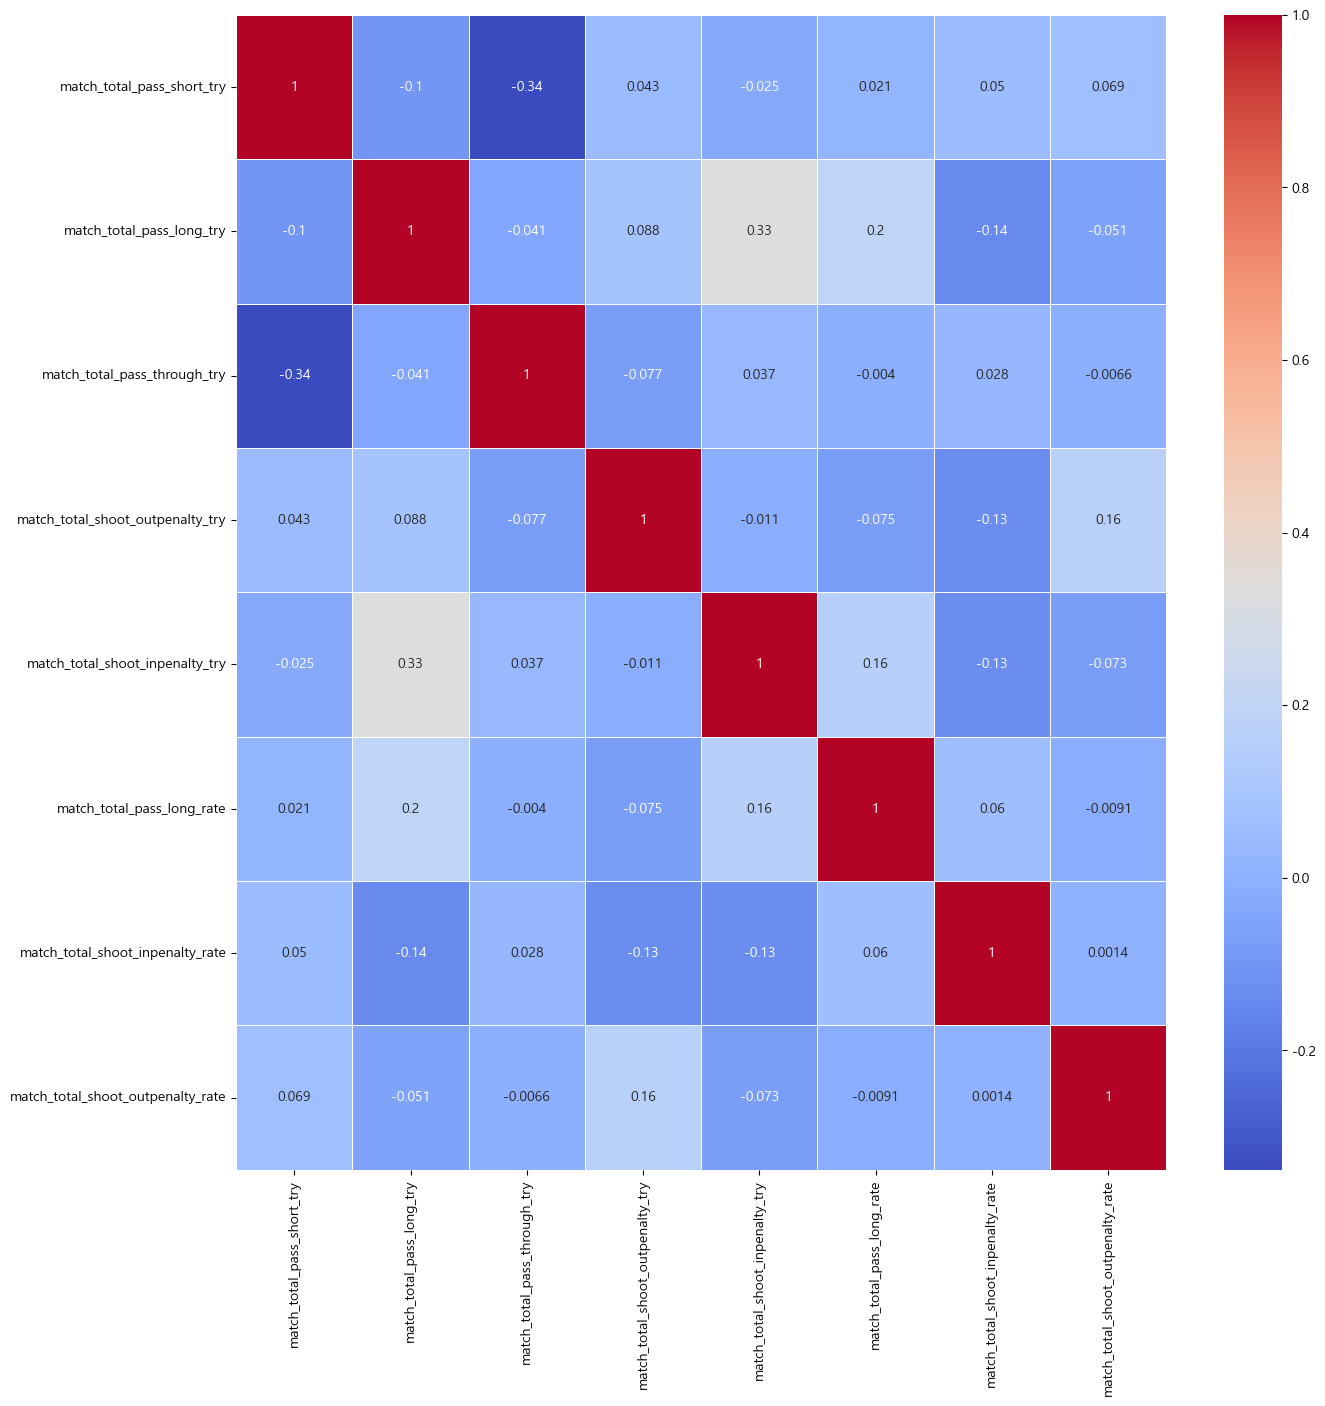

In [204]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(df2_temp.corr(), annot = True, linewidths = .5, cmap = 'coolwarm')
plt.show()

In [205]:
threshold = 0.8
corr_matrix = df2_temp.corr()

strong_corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))  
    .stack()   
    .reset_index()    
)

strong_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Correlation'] > threshold]

print(strong_corr_pairs)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


In [206]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 출력 함수
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return vif

vif_data = calculate_vif(df2_temp)
vif_data

Variable       VIF
0         match_total_pass_short_try  6.352092
1          match_total_pass_long_try  4.071168
2       match_total_pass_through_try  3.998106
3   match_total_shoot_outpenalty_try  2.484097
4    match_total_shoot_inpenalty_try  5.417812
5         match_total_pass_long_rate  3.942241
6   match_total_shoot_inpenalty_rate  3.054001
7  match_total_shoot_outpenalty_rate  1.389138

---

---

In [94]:
basic_col = ['match_possession', 
             'match_avg_rating', 
             'match_total_dribble', 
             'match_total_goal', 
             'match_total_shoot']

position_ratings_col = ['attack_position_ratings', 
                        'middle_position_ratings', 
                        'defense_position_ratings', 
                        'goalkeeper_position_ratings']

pass_col = ['match_total_pass_try', 
            'match_total_pass_short_try',
            'match_total_pass_long_try',
            'match_total_pass_through_try']

shoot_col = ['match_total_shoot', 
             'match_total_shoot_eff', 
             'match_total_shoot_outpenalty_try', 
             'match_total_shoot_inpenalty_try']

rate_col = ['match_total_pass_rate',
            'match_total_pass_short_rate', 
            'match_total_pass_long_rate', 
            'match_total_pass_through_rate', 
            'match_total_shoot_inpenalty_rate', 
            'match_total_shoot_outpenalty_rate']

In [118]:
df3 = df1.copy()

df3_win = df3[df3['match_result'] == '승']
df3_draw = df3[df3['match_result'] == '무']
df3_lose = df3[df3['match_result'] == '패']

## Stat별 HIST

In [207]:
def col_hist_all(_df, _col_name) : 
    fig, ax = plt.subplots(ncols = len(_col_name), 
                           figsize = (3.5 * len(_col_name), 6))
                           
    if len(_col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')

    for idx, col in enumerate(_col_name):
        bins = 15
        
        sns.histplot(_df[col].values, color = 'green', kde = True, ax = ax[idx], 
                     bins = bins, alpha = 0.6, stat = 'count')   
        
        ax[idx].set_title(_col_name[idx])
        ax[idx].set_xlim(0, max(0, max(_df[col])))

    plt.tight_layout()
    plt.show()

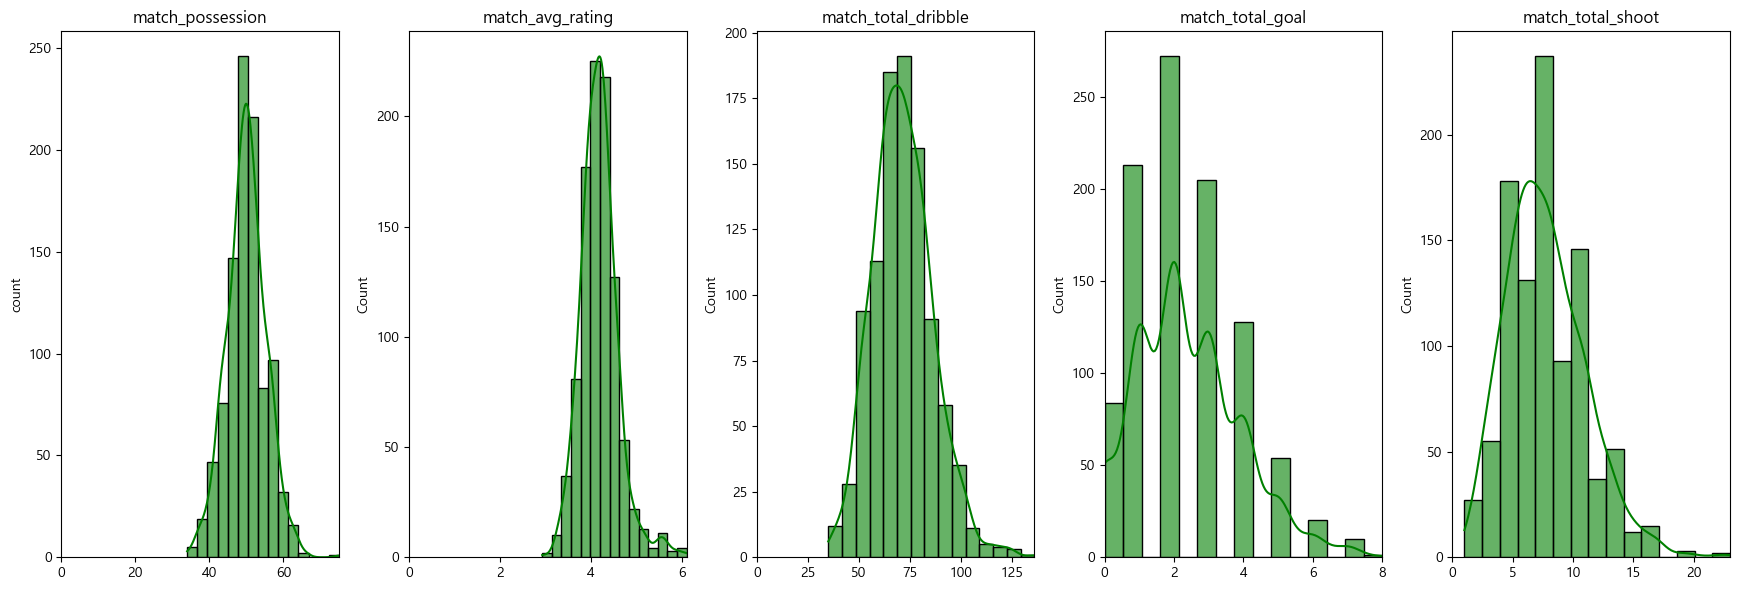

In [208]:
col_hist_all(df3, basic_col)

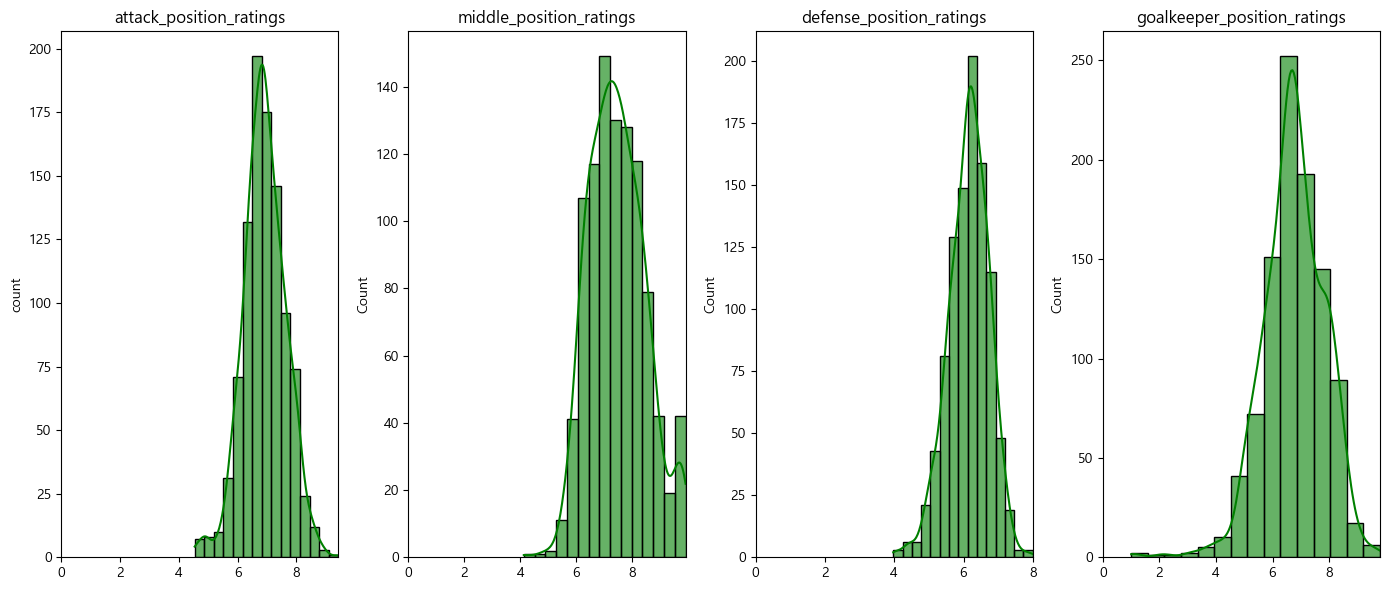

In [209]:
col_hist_all(df3, position_ratings_col)

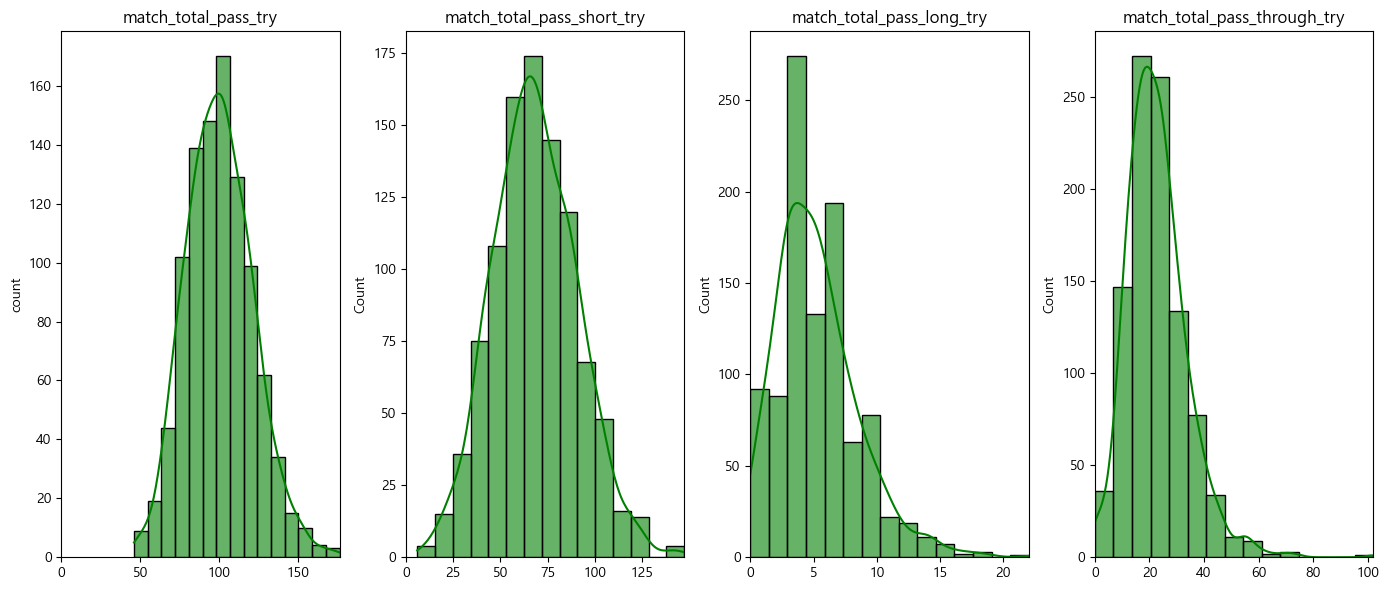

In [210]:
col_hist_all(df3, pass_col)

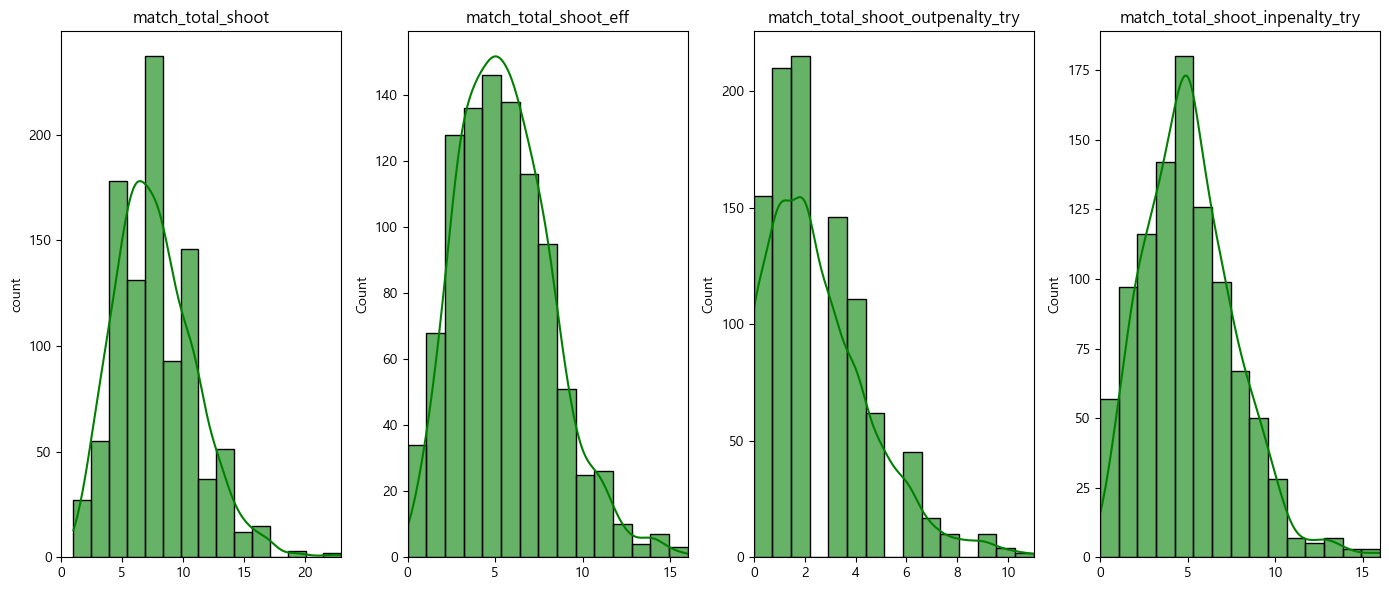

In [211]:
col_hist_all(df3, shoot_col)

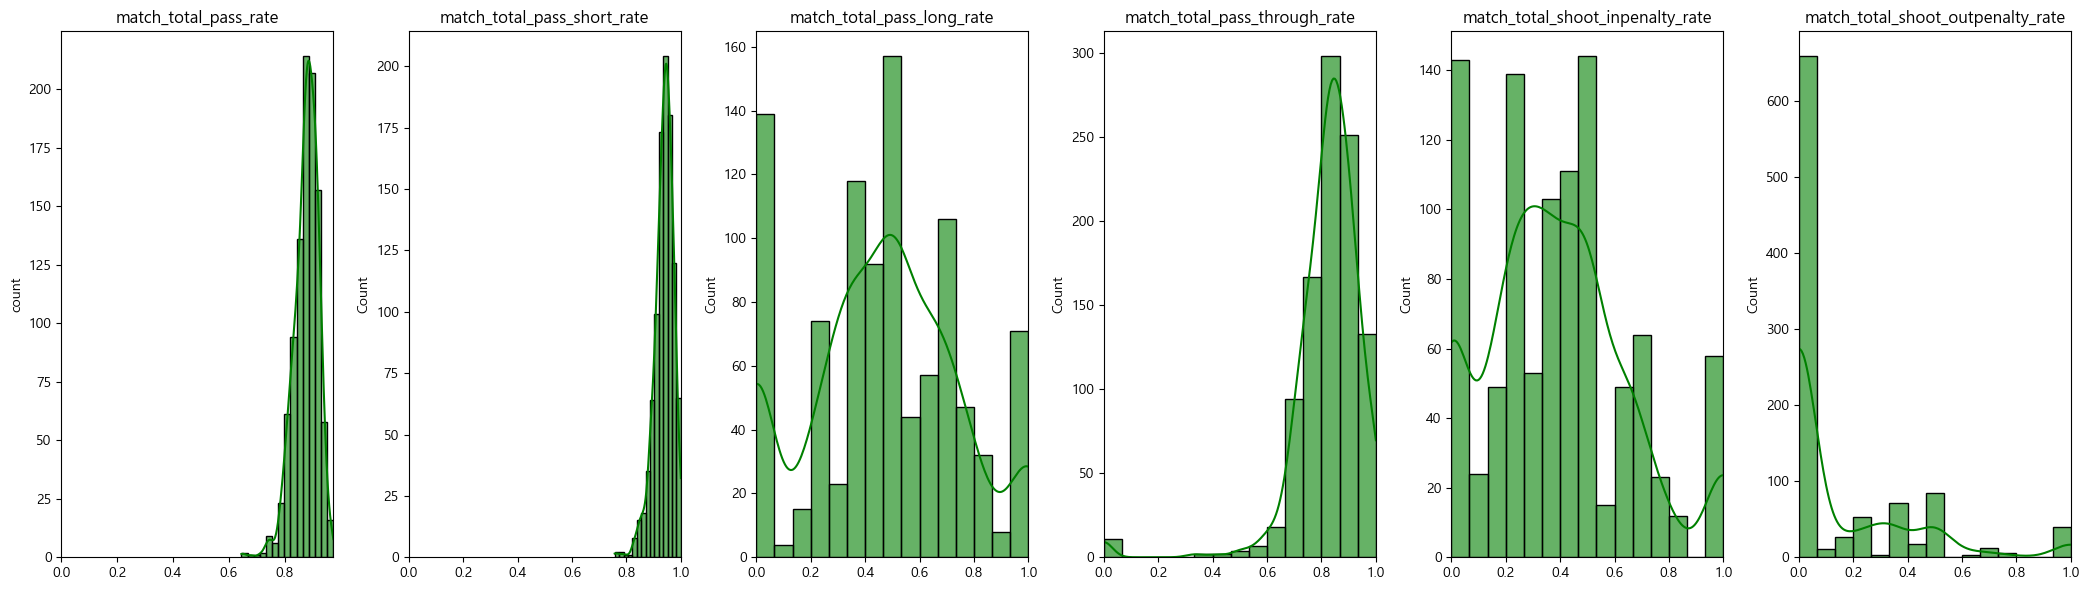

In [212]:
col_hist_all(df3, rate_col)

---

## 승, 패에 따른 Stat별 HIST

In [213]:
def col_hist(_df_win, _df_lose, _col_name) : 
    fig, ax = plt.subplots(ncols = len(_col_name), 
                           figsize = (3.5 * len(_col_name), 6))
                           
    if len(_col_name) == 1:
        ax = [ax]
        
    ax[0].set_ylabel('count')

    for idx, col in enumerate(_col_name):
        bins = 10 
        
        sns.histplot(_df_win[col].values, color = 'blue', kde = True, ax = ax[idx], label = '승', 
                     bins = bins, alpha = 0.6)
        sns.histplot(_df_lose[col].values, color = 'red', kde = True, ax = ax[idx], label = '패', 
                     bins = bins, alpha = 0.6)   
        
        ax[idx].set_title(_col_name[idx])
        ax[idx].legend()
    
    plt.tight_layout()
    plt.show()

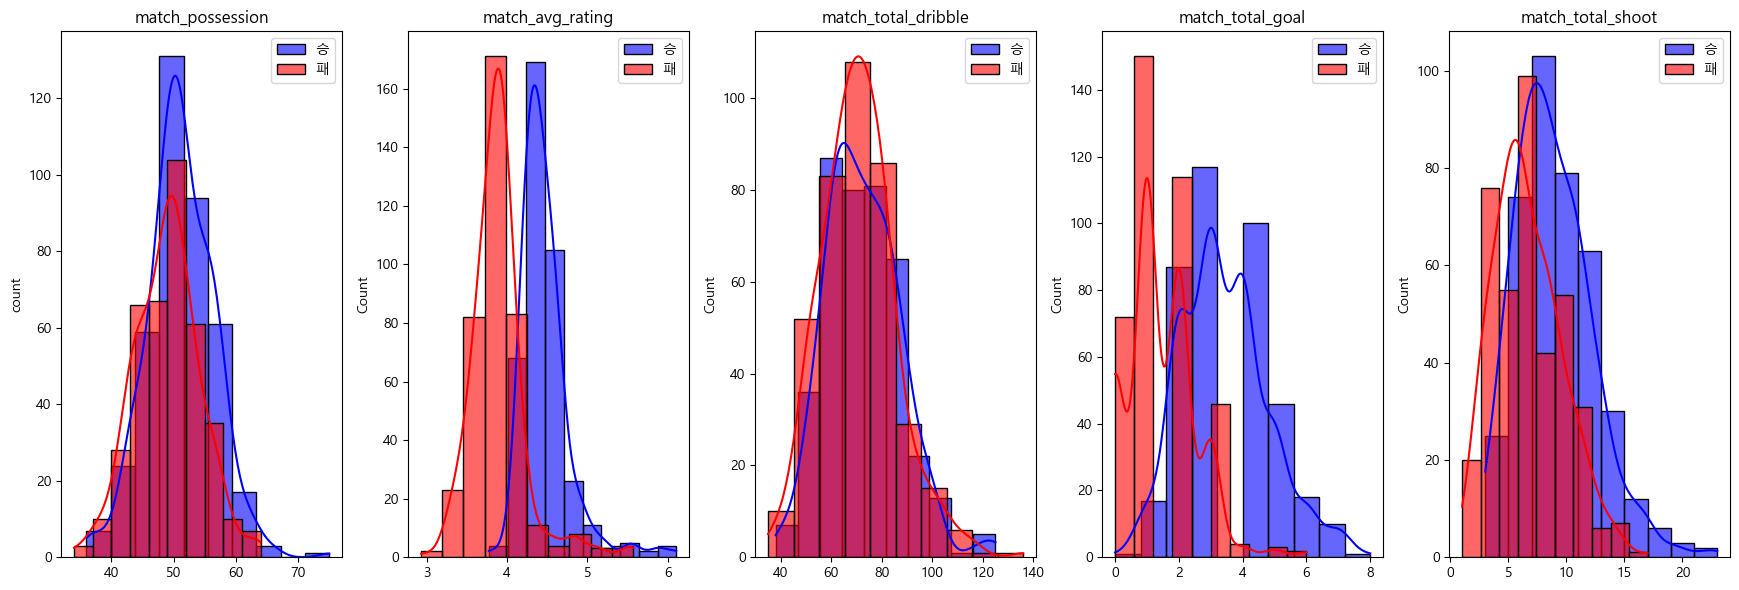

In [214]:
col_hist(df3_win, df3_lose, basic_col)

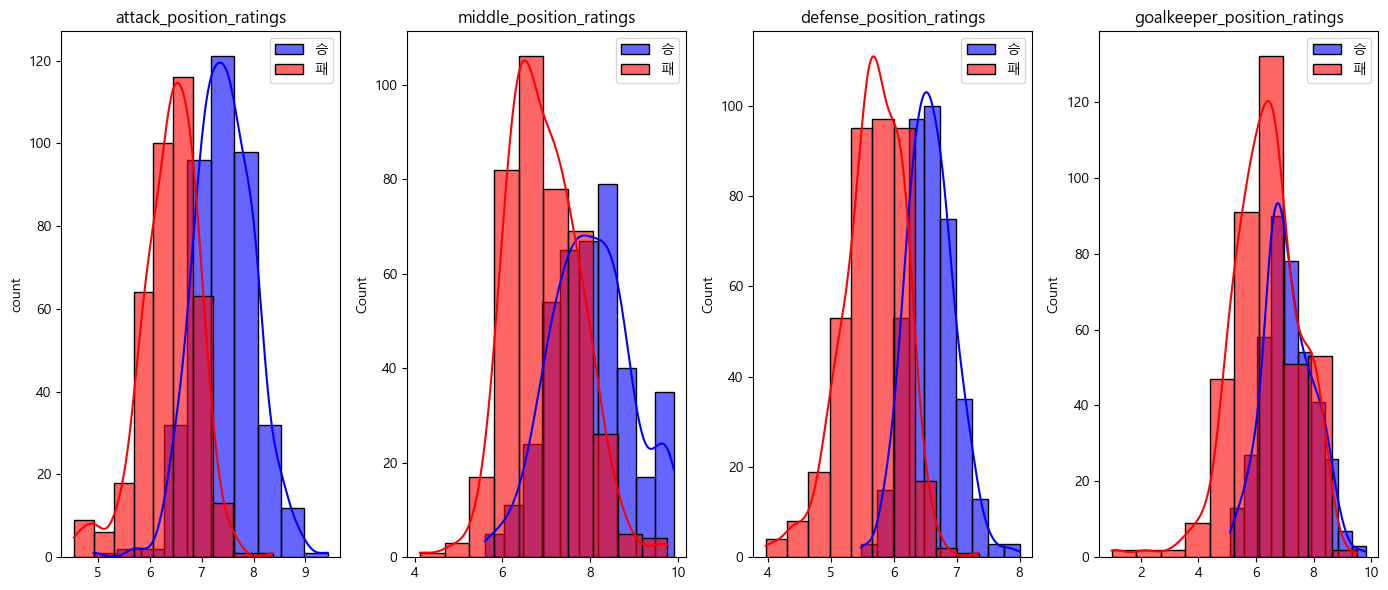

In [215]:
col_hist(df3_win, df3_lose, position_ratings_col)

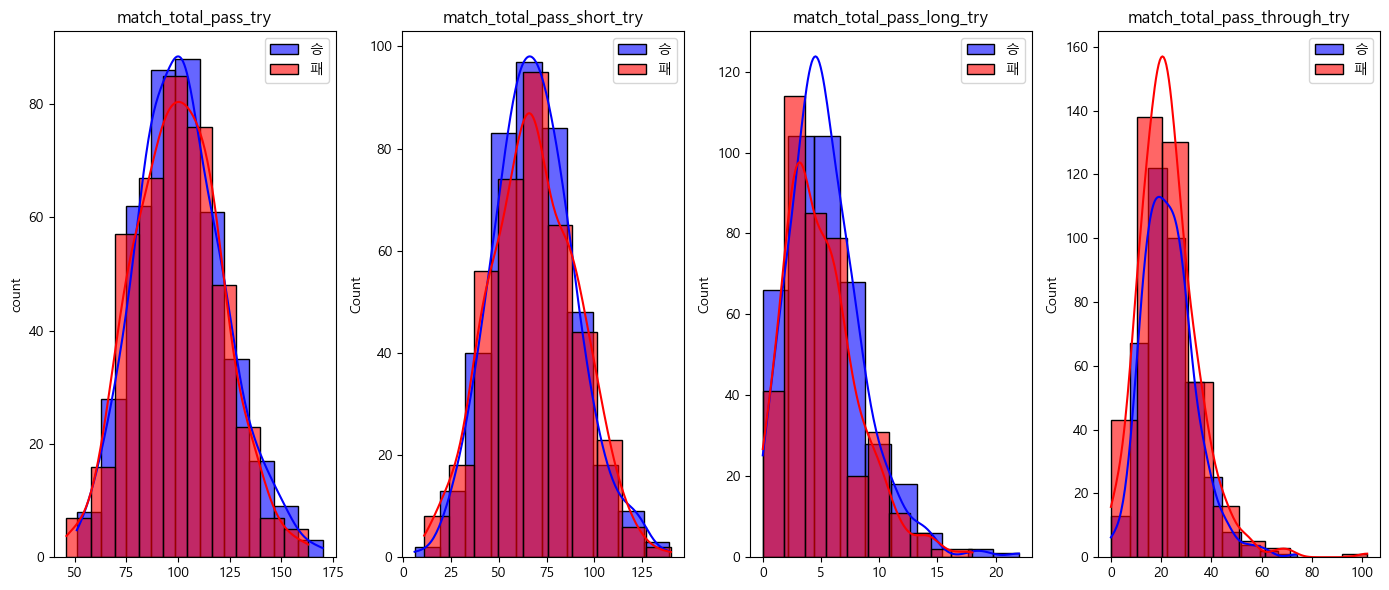

In [216]:
col_hist(df3_win, df3_lose, pass_col)

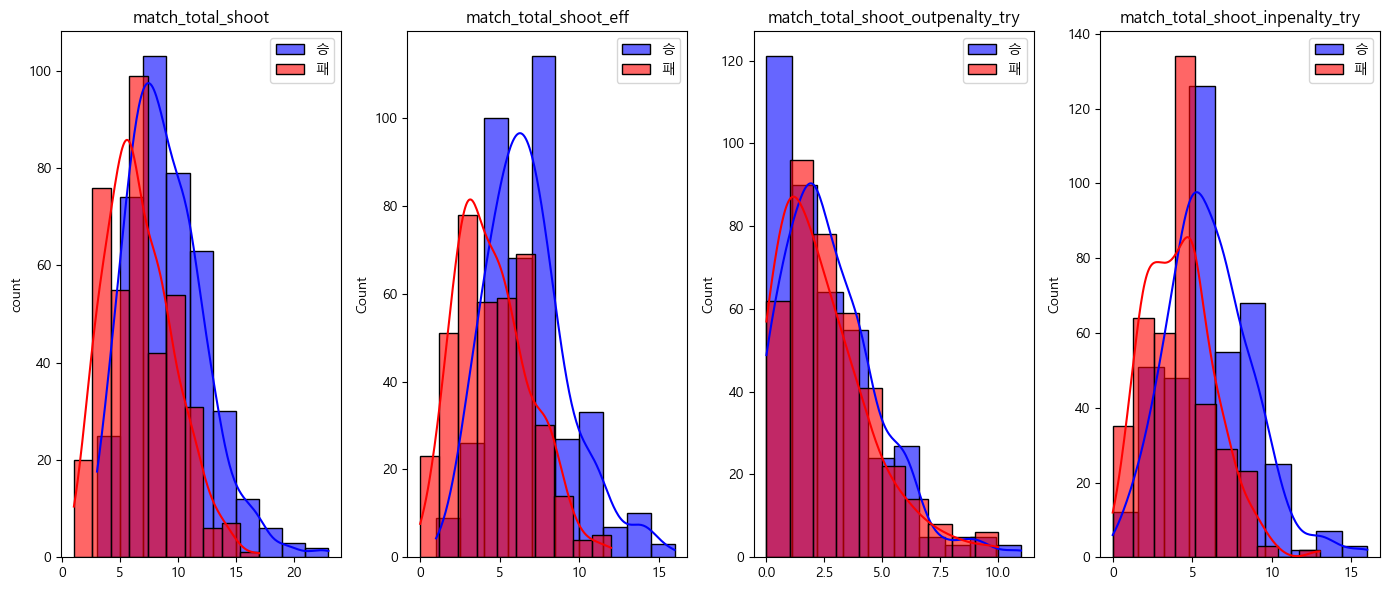

In [217]:
col_hist(df3_win, df3_lose, shoot_col)

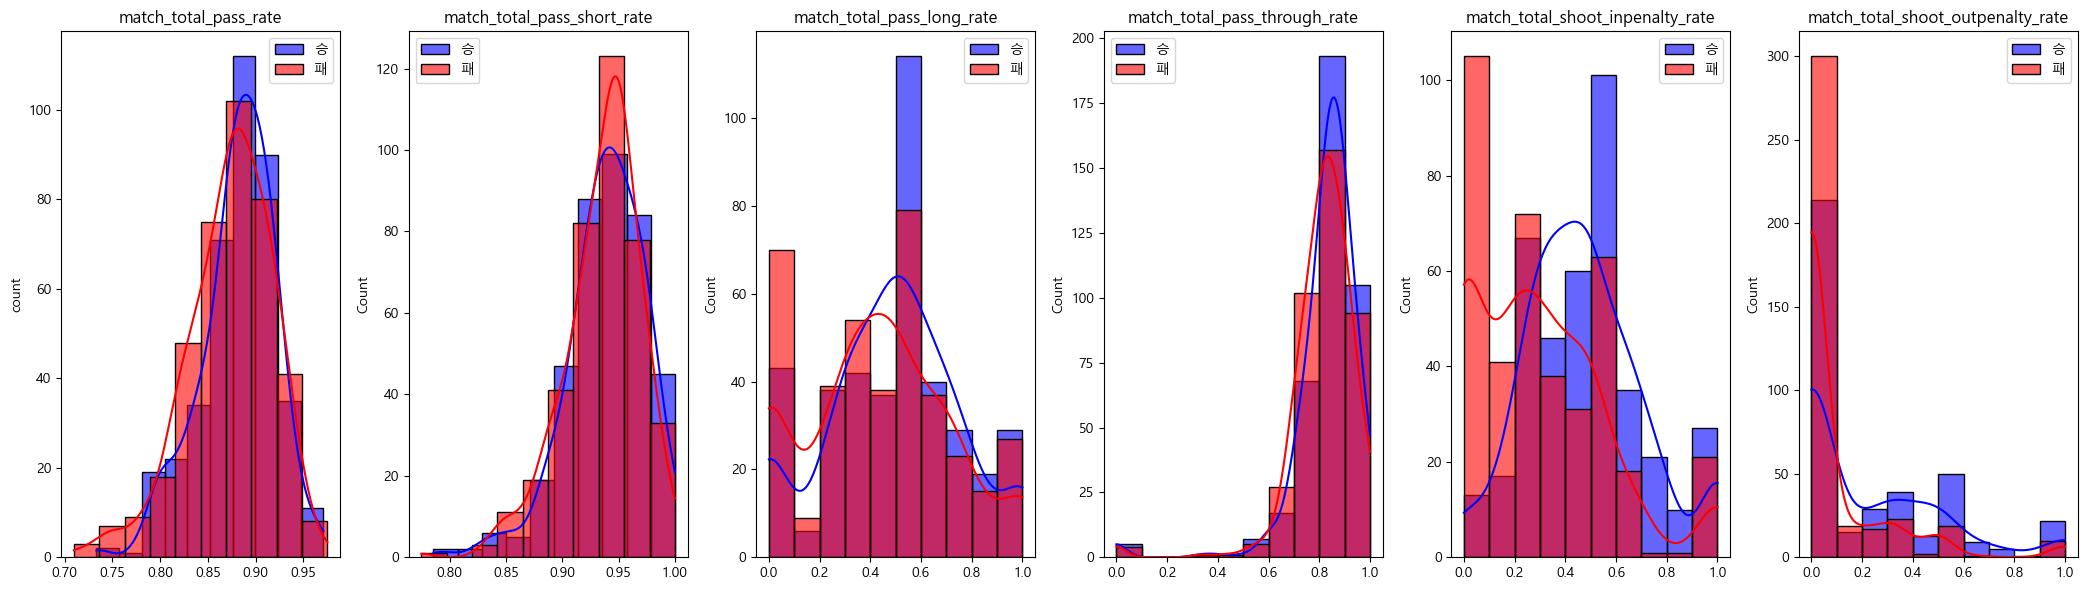

In [218]:
col_hist(df3_win, df3_lose, rate_col)

## 경기 결과에 따른 Stat별  Box-Plot

In [219]:
def col_boxplot(_df_win, _df_lose, _col_name, _sharey_bool = False) : 

    title_list = ['승', '패']

    fig, ax = plt.subplots(ncols = len(_col_name), 
                           figsize = (3.5 * len(_col_name), 6), 
                           sharey = _sharey_bool)
                           
    if len(_col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')

    for idx, col in enumerate(_col_name):
        data_to_plot = [_df_win[col].values, _df_lose[col].values]
        ax[idx].boxplot(data_to_plot, tick_labels = title_list);  

        ax[idx].set_xticks([i for i in range(1, len(title_list) + 1)])
        ax[idx].set_xticklabels(title_list)

        ax[idx].set_title(_col_name[idx])

### 승, 패에 따른 Basic Stats

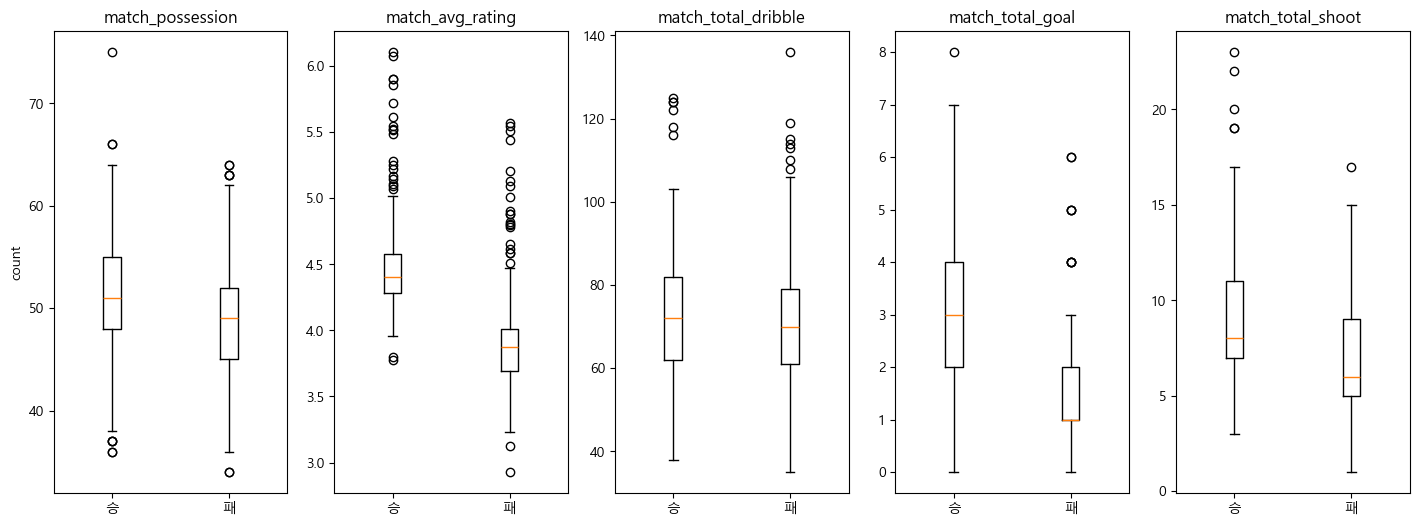

In [220]:
col_boxplot(df3_win, df3_lose, basic_col)

### 승, 패에  따른 Position 별 Ratings

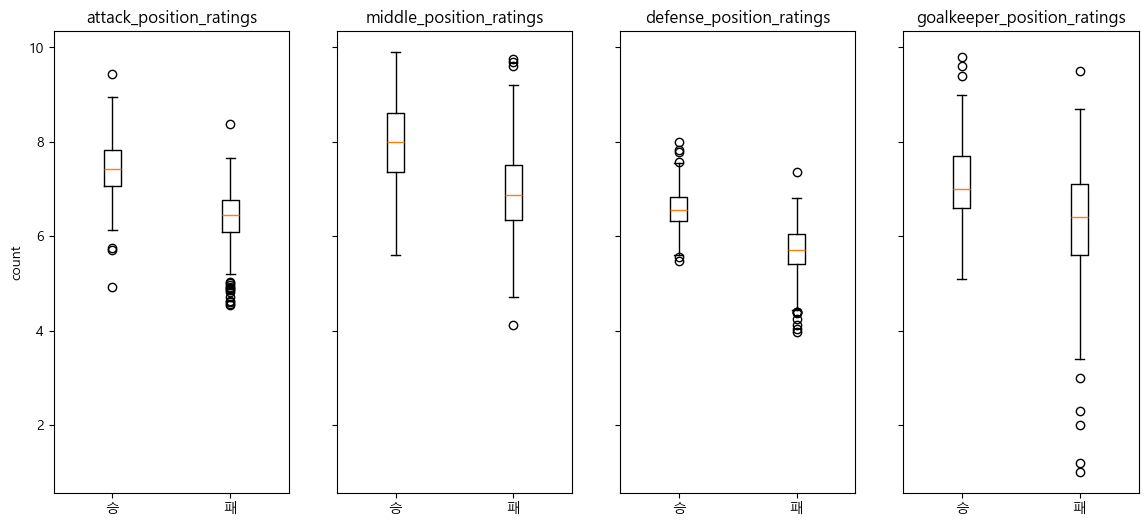

In [221]:
col_boxplot(df3_win, df3_lose, position_ratings_col, True)

### 승, 패에 따른 Pass stats

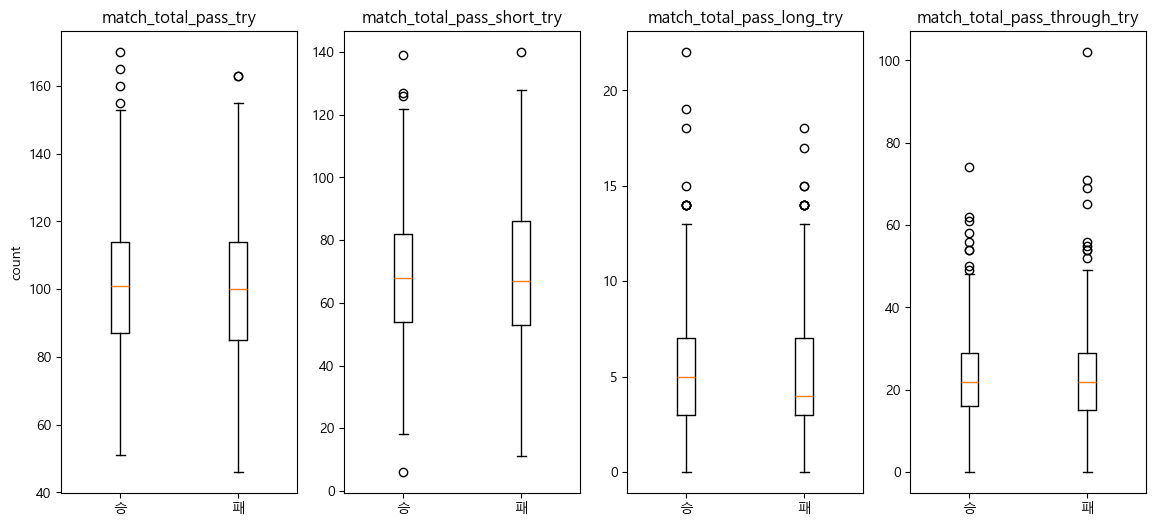

In [222]:
col_boxplot(df3_win, df3_lose, pass_col)

### 승, 패에 따른 Shoot stats

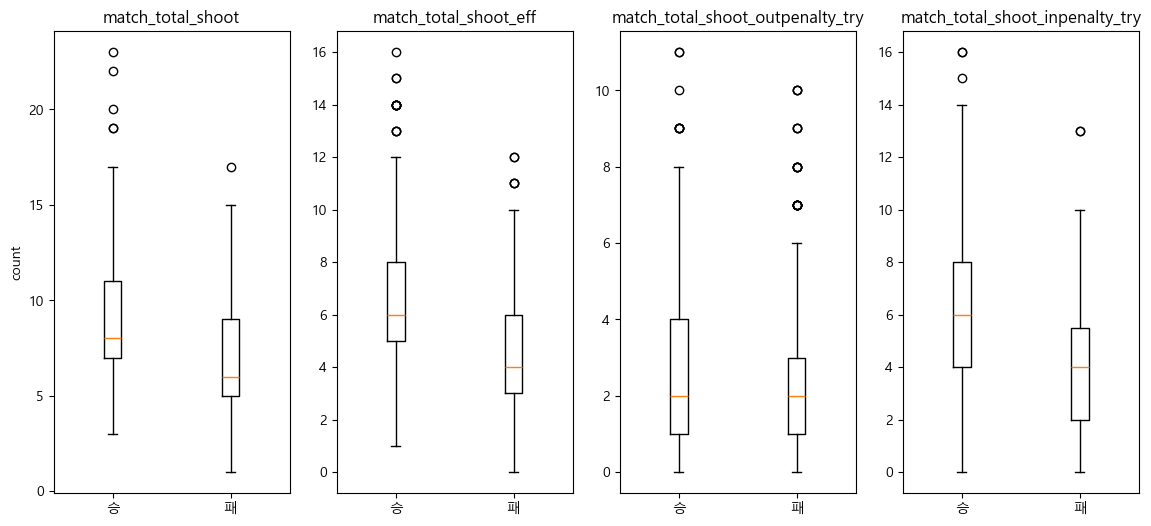

In [223]:
col_boxplot(df3_win, df3_lose, shoot_col)

### 승, 패에 따른 Rate stats

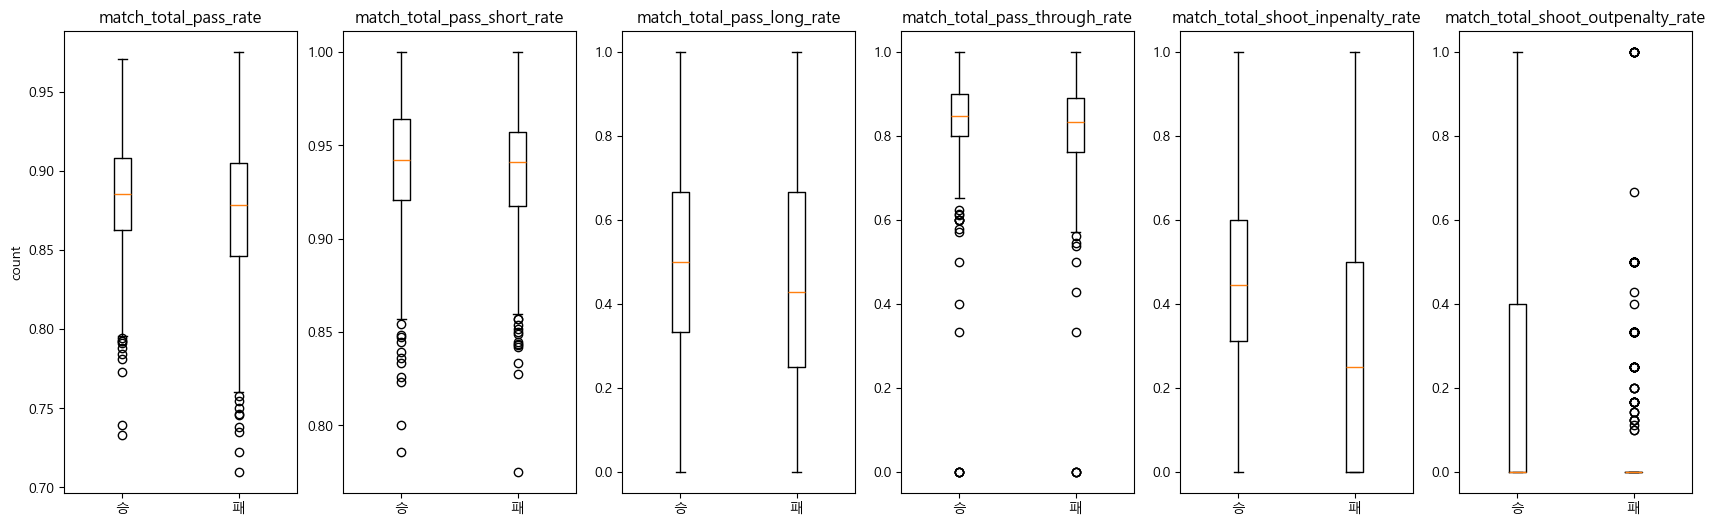

In [224]:
col_boxplot(df3_win, df3_lose, rate_col)

---

In [225]:
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu, kstest, norm, probplot

from sklearn.preprocessing import power_transform

In [226]:
df3_qq = df3.copy()

## Stat별 QQ plot

In [227]:
def col_qqplot_all(_df, _col_name) : 
    fig, ax = plt.subplots(ncols = len(_col_name), 
                           figsize = (3.5 * len(_col_name), 6))
                           
    if len(_col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')

    for idx, col in enumerate(_col_name):
        stats.probplot(_df[col], dist = "norm", plot = ax[idx])
        
        ax[idx].set_title(_col_name[idx])

    plt.tight_layout()
    plt.show()

In [228]:
def col_qqplot_norm_all(_df, _col_name) : 
    fig, ax = plt.subplots(ncols = len(_col_name), 
                           figsize = (3.5 * len(_col_name), 6))
                           
    if len(_col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')
    
    for idx, col in enumerate(_col_name):
        _df[col] = power_transform(_df[col].values.reshape(-1, 1), method = 'yeo-johnson')

        stats.probplot(_df[col], dist = "norm", plot = ax[idx])
        
        ax[idx].set_title(_col_name[idx])

    plt.tight_layout()
    plt.show()

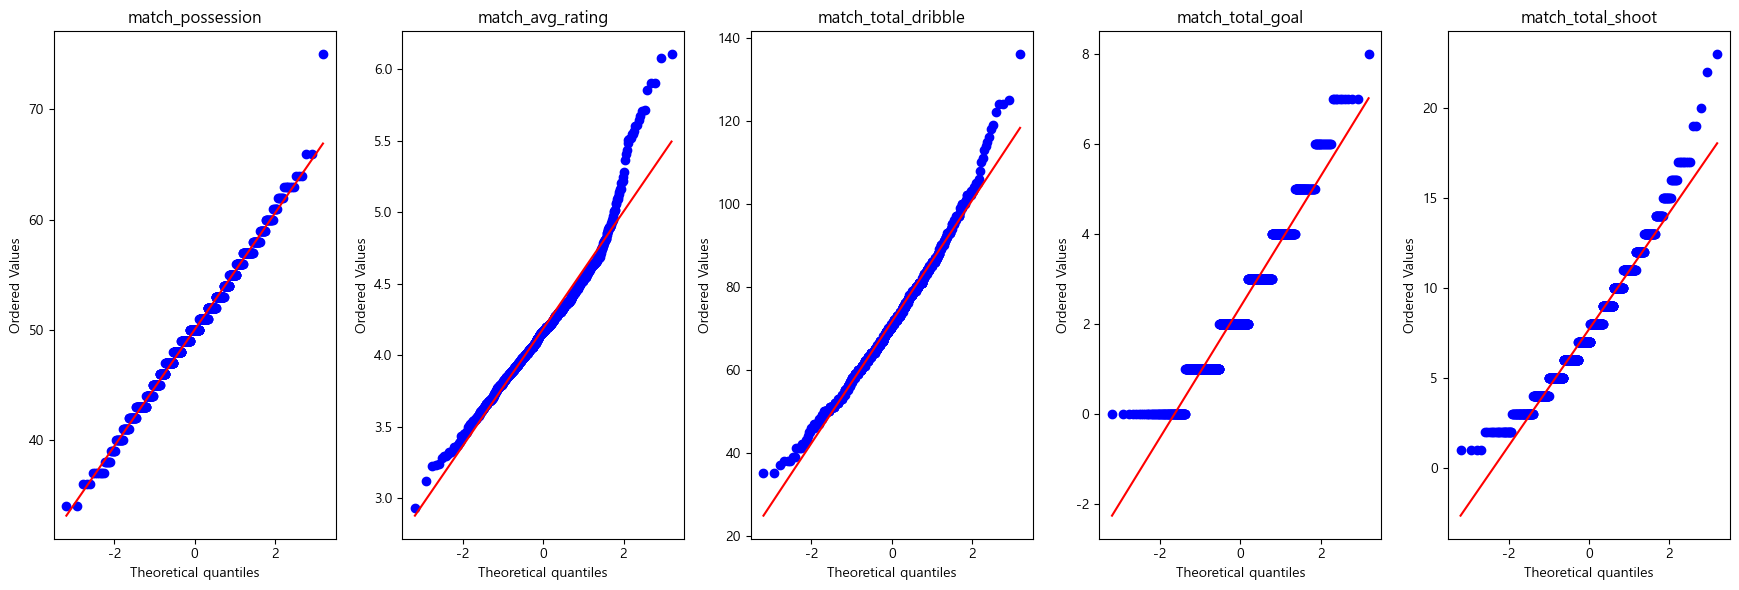

In [229]:
col_qqplot_all(df3, basic_col)

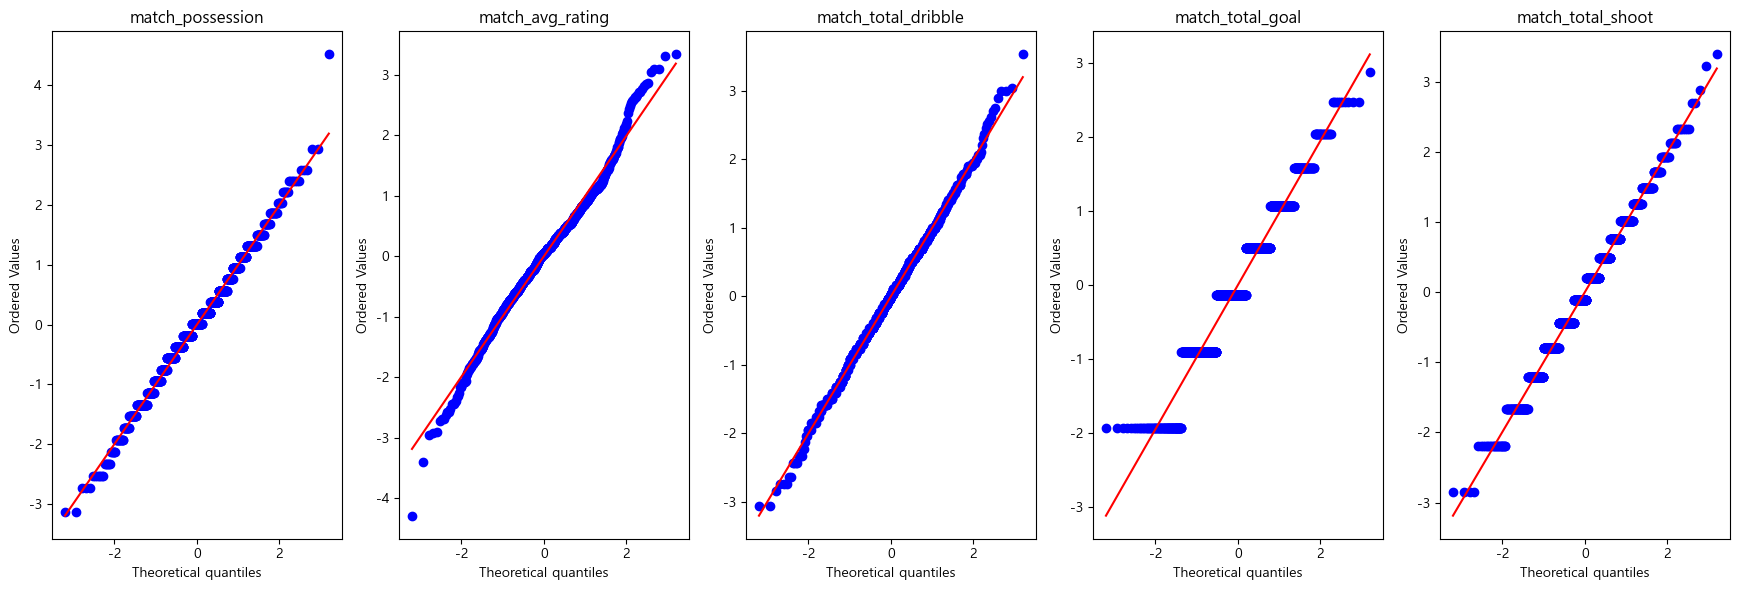

In [230]:
col_qqplot_norm_all(df3_qq, basic_col)

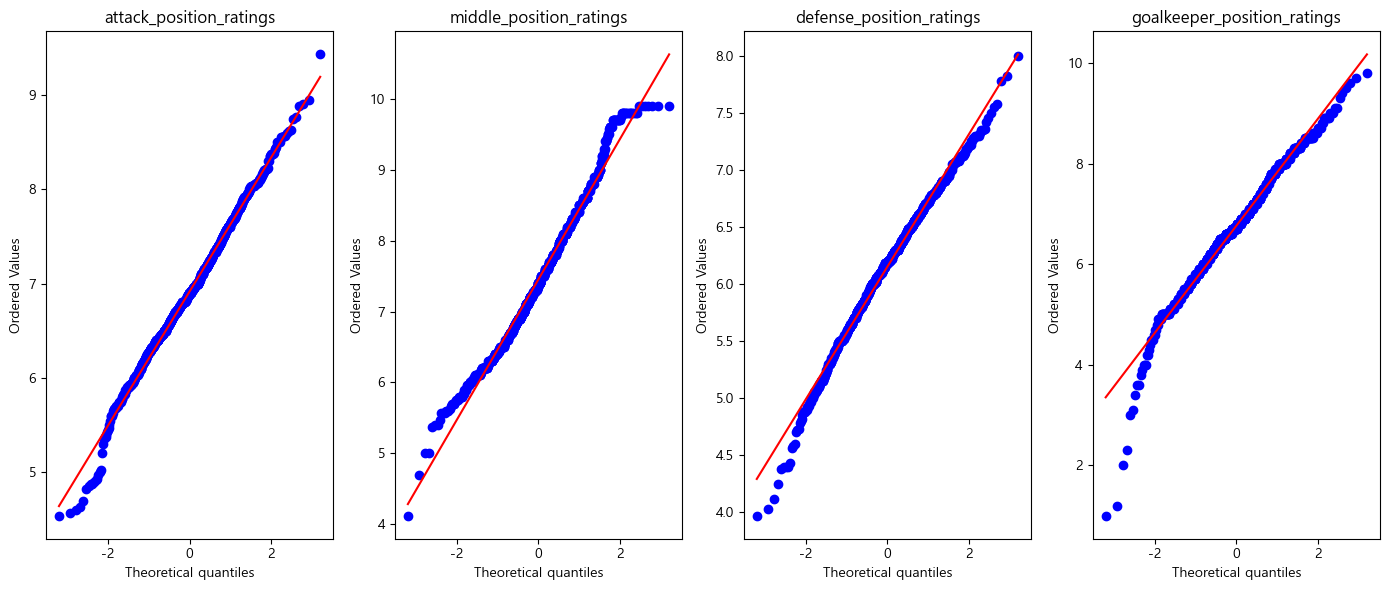

In [231]:
col_qqplot_all(df3, position_ratings_col)

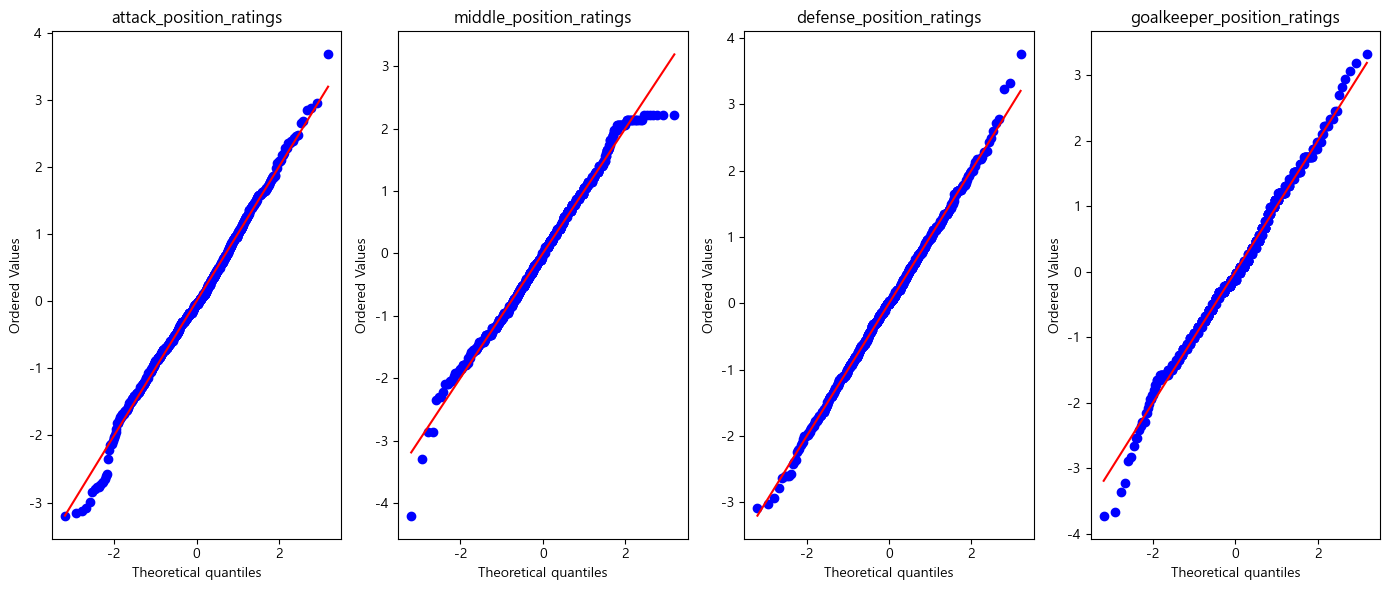

In [232]:
col_qqplot_norm_all(df3_qq, position_ratings_col)

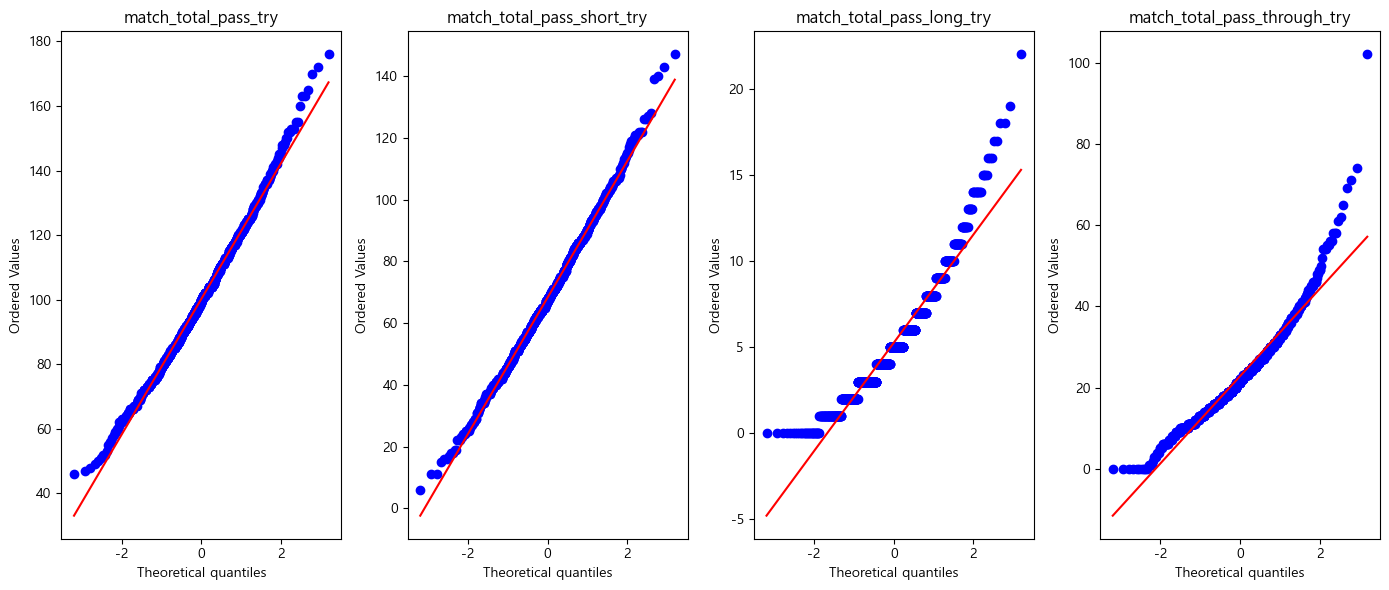

In [233]:
col_qqplot_all(df3, pass_col)

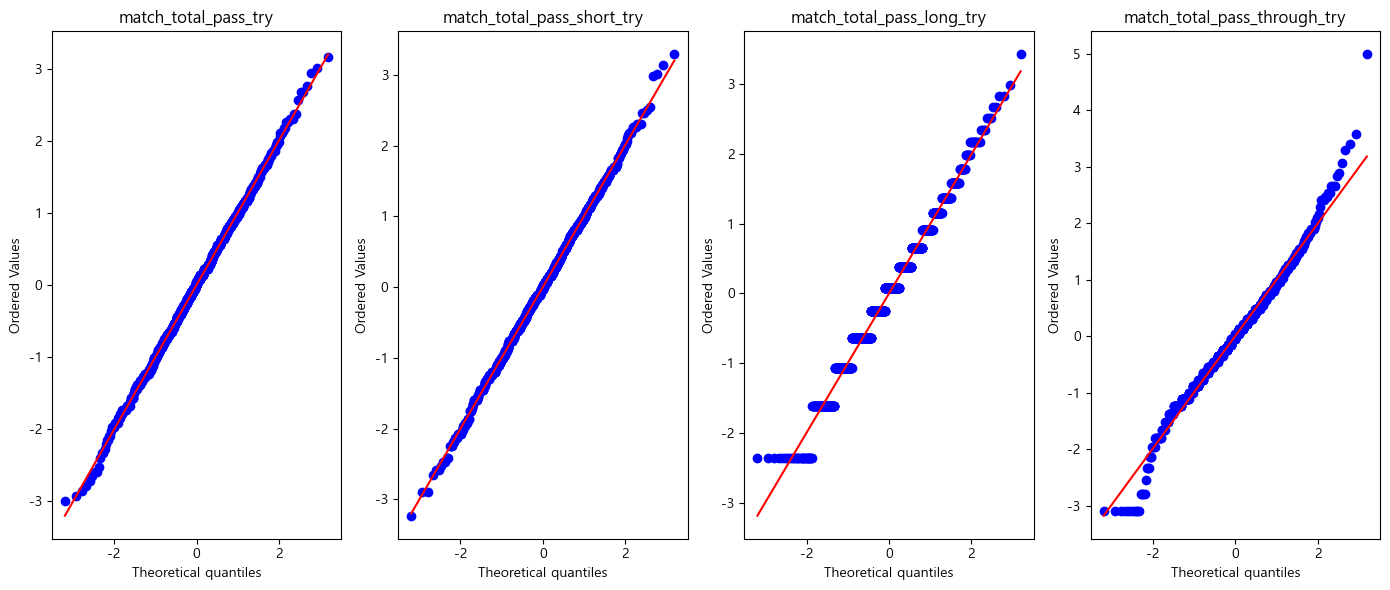

In [234]:
col_qqplot_norm_all(df3_qq, pass_col)

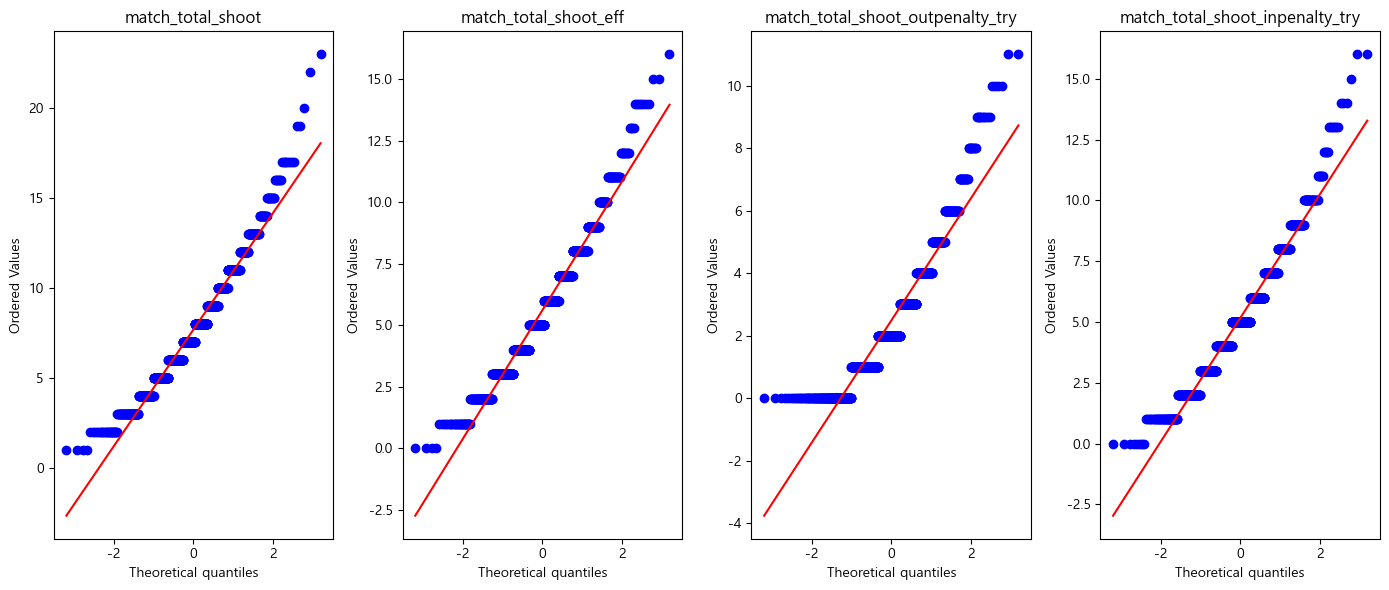

In [235]:
col_qqplot_all(df3, shoot_col)

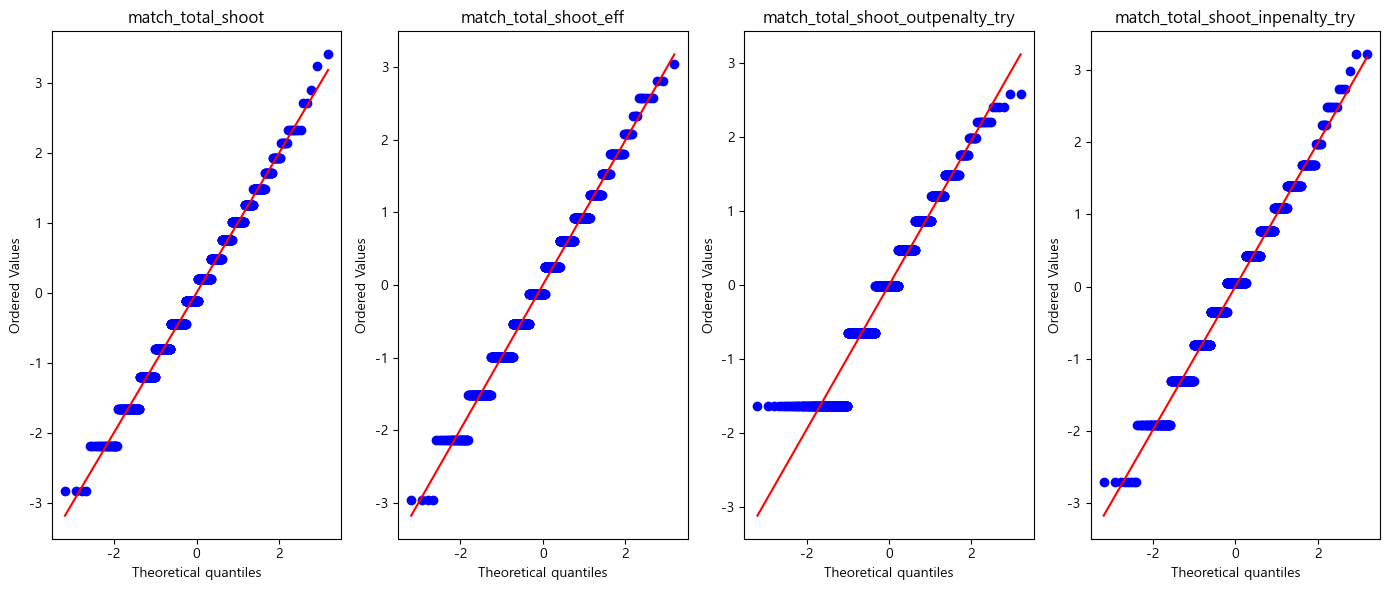

In [236]:
col_qqplot_norm_all(df3_qq, shoot_col)

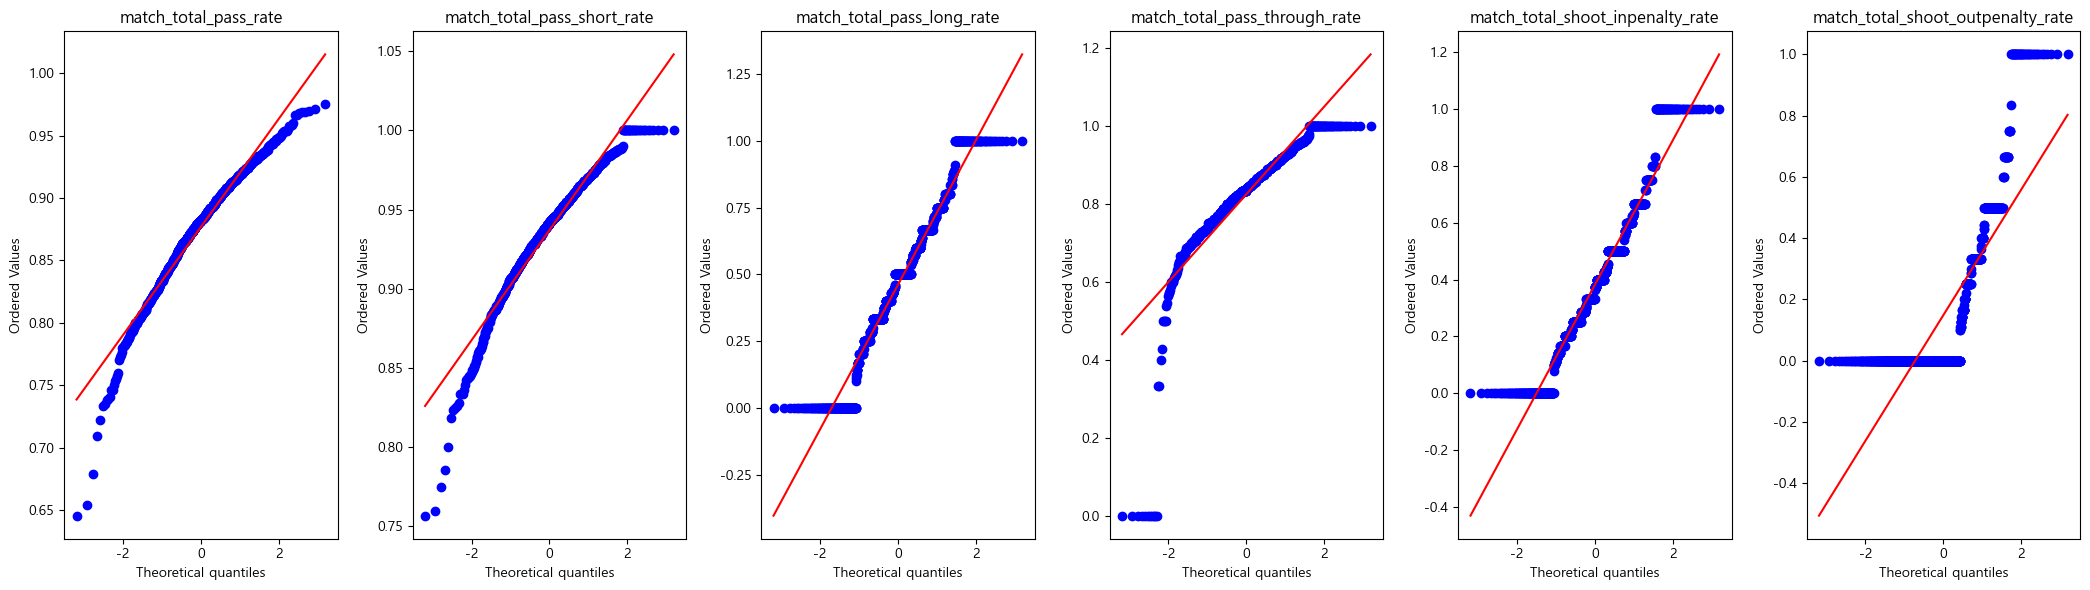

In [237]:
col_qqplot_all(df3, rate_col)

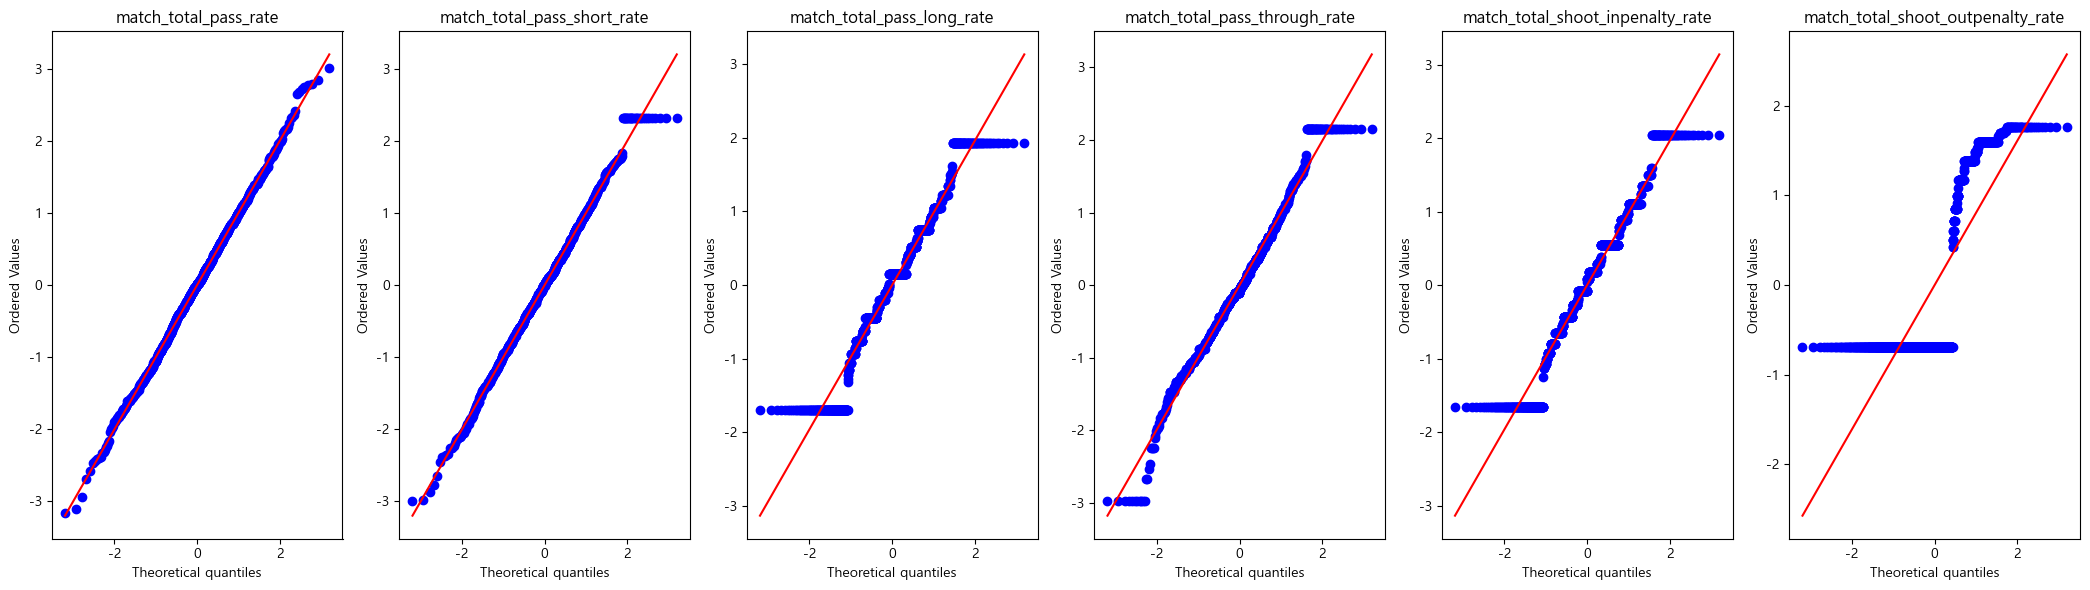

In [238]:
col_qqplot_norm_all(df3_qq, rate_col)

In [239]:
df3_qq_win = df3_qq[df3_qq['match_result'] == '승']
df3_qq_lose = df3_qq[df3_qq['match_result'] == '패']

---

---

In [240]:
# 1. 정규성 검정 (Shapiro-Wilk test)
def normality_test(_df, _df_win, _df_lose, _columns):
    columns_normality_O = []
    columns_normality_X = []
    
    columns_homogeneity_O = []
    columns_homogeneity_X = []

    for col in _columns:
        stat_shap, p_val_shap = shapiro(_df[col])
        stat_win_shap, p_val_win_shap = shapiro(_df_win[col])
        stat_lose_shap, p_val_lose_shap = shapiro(_df_lose[col])
        
        stat_kosm, p_val_kosm = kstest(_df[col], 'norm', args = (_df[col].mean(), _df[col].std()))
        stat_win_kosm, p_val_win_kosm = kstest(_df_win[col], 'norm', args = (_df_win[col].mean(), _df_win[col].std()))
        stat_lose_kosm, p_val_lose_kosm = kstest(_df_lose[col], 'norm', args = (_df_lose[col].mean(), _df_lose[col].std()))
        
        stat, p_val = levene(_df_win[col], _df_lose[col])

        # print(f'{col} \n 정규성 검정: \n 전체: p-value={p_val_shap} \
        #                              \n 승: p-value={p_val_win_shap, p_val_win_kosm} \
        #                              \n 패: p-value={p_val_lose_shap, p_val_lose_kosm} \
        #                              \n Levene’s test p-value={p_val}')
              
        if p_val_shap > 0.05 or (p_val_win_shap > 0.05 and p_val_lose_shap > 0.05):
            columns_normality_O.append(col) 

        else:
            if p_val_kosm > 0.05 or (p_val_win_kosm > 0.05 and p_val_lose_kosm) > 0.05:
                columns_normality_O.append(col)  

            else:
                columns_normality_X.append(col) 

        # 등분산성 검정 결과
        if p_val > 0.05:
            columns_homogeneity_O.append(col)  
            
        else:
            columns_homogeneity_X.append(col) 

    print('-----------------------------------------------------')
    print(f"정규분포 O: \n {', '.join(columns_normality_O)}")
    print('-----------------------------------------------------')
    print(f"정규분포 X: \n {', '.join(columns_normality_X)}")
    print('-----------------------------------------------------')
    print(f"등분산성 O: \n {', '.join(columns_homogeneity_O)}")
    print('-----------------------------------------------------')
    print(f"등분산성 X: \n {', '.join(columns_homogeneity_X)}")
    print('-----------------------------------------------------')

### 정규화 전 정규성, 등분산성 확인

In [241]:
normality_test(df3, df3_win, df3_lose, basic_col)

-----------------------------------------------------
정규분포 O: 
 match_possession, match_total_dribble
-----------------------------------------------------
정규분포 X: 
 match_avg_rating, match_total_goal, match_total_shoot
-----------------------------------------------------
등분산성 O: 
 match_possession, match_avg_rating, match_total_dribble, match_total_shoot
-----------------------------------------------------
등분산성 X: 
 match_total_goal
-----------------------------------------------------


In [242]:
normality_test(df3, df3_win, df3_lose, position_ratings_col)

-----------------------------------------------------
정규분포 O: 
 attack_position_ratings, middle_position_ratings, defense_position_ratings
-----------------------------------------------------
정규분포 X: 
 goalkeeper_position_ratings
-----------------------------------------------------
등분산성 O: 
 attack_position_ratings
-----------------------------------------------------
등분산성 X: 
 middle_position_ratings, defense_position_ratings, goalkeeper_position_ratings
-----------------------------------------------------


In [243]:
normality_test(df3, df3_win, df3_lose, pass_col)

-----------------------------------------------------
정규분포 O: 
 match_total_pass_try, match_total_pass_short_try
-----------------------------------------------------
정규분포 X: 
 match_total_pass_long_try, match_total_pass_through_try
-----------------------------------------------------
등분산성 O: 
 match_total_pass_try, match_total_pass_short_try, match_total_pass_long_try, match_total_pass_through_try
-----------------------------------------------------
등분산성 X: 
 
-----------------------------------------------------


In [244]:
normality_test(df3, df3_win, df3_lose, shoot_col)

-----------------------------------------------------
정규분포 O: 
 
-----------------------------------------------------
정규분포 X: 
 match_total_shoot, match_total_shoot_eff, match_total_shoot_outpenalty_try, match_total_shoot_inpenalty_try
-----------------------------------------------------
등분산성 O: 
 match_total_shoot, match_total_shoot_eff, match_total_shoot_outpenalty_try
-----------------------------------------------------
등분산성 X: 
 match_total_shoot_inpenalty_try
-----------------------------------------------------


In [245]:
normality_test(df3, df3_win, df3_lose, rate_col)

-----------------------------------------------------
정규분포 O: 
 
-----------------------------------------------------
정규분포 X: 
 match_total_pass_rate, match_total_pass_short_rate, match_total_pass_long_rate, match_total_pass_through_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------
등분산성 O: 
 match_total_pass_short_rate, match_total_pass_through_rate
-----------------------------------------------------
등분산성 X: 
 match_total_pass_rate, match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------


### 정규화 이후 정규성, 등분산성 확인

In [246]:
normality_test(df3_qq, df3_qq_win, df3_qq_lose, basic_col)

-----------------------------------------------------
정규분포 O: 
 match_possession, match_avg_rating, match_total_dribble
-----------------------------------------------------
정규분포 X: 
 match_total_goal, match_total_shoot
-----------------------------------------------------
등분산성 O: 
 match_possession, match_total_dribble, match_total_goal, match_total_shoot
-----------------------------------------------------
등분산성 X: 
 match_avg_rating
-----------------------------------------------------


In [247]:
normality_test(df3_qq, df3_qq_win, df3_qq_lose, position_ratings_col)

-----------------------------------------------------
정규분포 O: 
 attack_position_ratings, middle_position_ratings, defense_position_ratings
-----------------------------------------------------
정규분포 X: 
 goalkeeper_position_ratings
-----------------------------------------------------
등분산성 O: 
 attack_position_ratings, middle_position_ratings, defense_position_ratings
-----------------------------------------------------
등분산성 X: 
 goalkeeper_position_ratings
-----------------------------------------------------


In [248]:
normality_test(df3_qq, df3_qq_win, df3_qq_lose, pass_col)

-----------------------------------------------------
정규분포 O: 
 match_total_pass_try, match_total_pass_short_try, match_total_pass_through_try
-----------------------------------------------------
정규분포 X: 
 match_total_pass_long_try
-----------------------------------------------------
등분산성 O: 
 match_total_pass_try, match_total_pass_short_try, match_total_pass_long_try, match_total_pass_through_try
-----------------------------------------------------
등분산성 X: 
 
-----------------------------------------------------


In [249]:
normality_test(df3_qq, df3_qq_win, df3_qq_lose, shoot_col)

-----------------------------------------------------
정규분포 O: 
 
-----------------------------------------------------
정규분포 X: 
 match_total_shoot, match_total_shoot_eff, match_total_shoot_outpenalty_try, match_total_shoot_inpenalty_try
-----------------------------------------------------
등분산성 O: 
 match_total_shoot, match_total_shoot_eff, match_total_shoot_outpenalty_try, match_total_shoot_inpenalty_try
-----------------------------------------------------
등분산성 X: 
 
-----------------------------------------------------


In [250]:
normality_test(df3_qq, df3_qq_win, df3_qq_lose, rate_col)

-----------------------------------------------------
정규분포 O: 
 match_total_pass_rate, match_total_pass_short_rate, match_total_pass_through_rate
-----------------------------------------------------
정규분포 X: 
 match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------
등분산성 O: 
 match_total_pass_rate, match_total_pass_short_rate, match_total_pass_through_rate
-----------------------------------------------------
등분산성 X: 
 match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------


In [251]:
def group_difference_test(_df_win, _df_lose, _columns):
    for col in _columns:
        # 정규성 여부에 따라 검정 방법 선택
        stat_win_shap, p_val_win_shap = shapiro(_df_win[col])
        stat_lose_shap, p_val_lose_shap = shapiro(_df_lose[col])
        
        stat_win_kosm, p_val_win_kosm = kstest(_df_win[col], 'norm', args = (_df_win[col].mean(), _df_win[col].std()))
        stat_lose_kosm, p_val_lose_kosm = kstest(_df_lose[col], 'norm', args = (_df_lose[col].mean(), _df_lose[col].std()))
        
        if (p_val_win_shap > 0.05 and p_val_lose_shap > 0.05) or (p_val_win_kosm > 0.05 and p_val_lose_kosm > 0.05):  # 정규분포를 따를 경우
            stat, p_val = ttest_ind(_df_win[col], _df_lose[col], equal_var = True)  
            test_type = "t-test"
            
        else:  # 정규분포를 따르지 않을 경우
            stat, p_val = mannwhitneyu(_df_win[col], _df_lose[col])
            test_type = "Mann-Whitney U test"
        
        print('-----------------------------------------------------')

        if p_val < 0.05:
            print(f'{col}은(는) 승패에 따라 유의미한 차이가 있음')
        else:
            print(f'{col}은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX')

In [252]:
group_difference_test(df3_win, df3_lose, basic_col)

-----------------------------------------------------
match_possession은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_avg_rating은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_dribble은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_goal은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot은(는) 승패에 따라 유의미한 차이가 있음


In [253]:
group_difference_test(df3_win, df3_lose, position_ratings_col)

-----------------------------------------------------
attack_position_ratings은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
middle_position_ratings은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
defense_position_ratings은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
goalkeeper_position_ratings은(는) 승패에 따라 유의미한 차이가 있음


In [254]:
group_difference_test(df3_win, df3_lose, shoot_col)

-----------------------------------------------------
match_total_shoot은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_eff은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_try은(는) 승패에 따라 유의미한 차이가 있음


In [255]:
group_difference_test(df3_win, df3_lose, pass_col)

-----------------------------------------------------
match_total_pass_try은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_pass_short_try은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_pass_long_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_through_try은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX


In [256]:
group_difference_test(df3_win, df3_lose, rate_col)

-----------------------------------------------------
match_total_pass_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_short_rate은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_pass_long_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_through_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_rate은(는) 승패에 따라 유의미한 차이가 있음


---

In [257]:
list(df2_temp.columns)

['match_total_pass_short_try',
 'match_total_pass_long_try',
 'match_total_pass_through_try',
 'match_total_shoot_outpenalty_try',
 'match_total_shoot_inpenalty_try',
 'match_total_pass_long_rate',
 'match_total_shoot_inpenalty_rate',
 'match_total_shoot_outpenalty_rate']

In [258]:
df4 = df1[['match_result'] + list(df2_temp.columns)]

df4_win = df4[df4['match_result'] == '승']
df4_lose = df4[df4['match_result'] == '패']

df4_temp = df4.drop(columns = ['match_result'])

df4_temp_qq = df4_temp.copy()
df4_temp_win_qq = df4_win.copy()
df4_temp_lose_qq = df4_lose.copy()

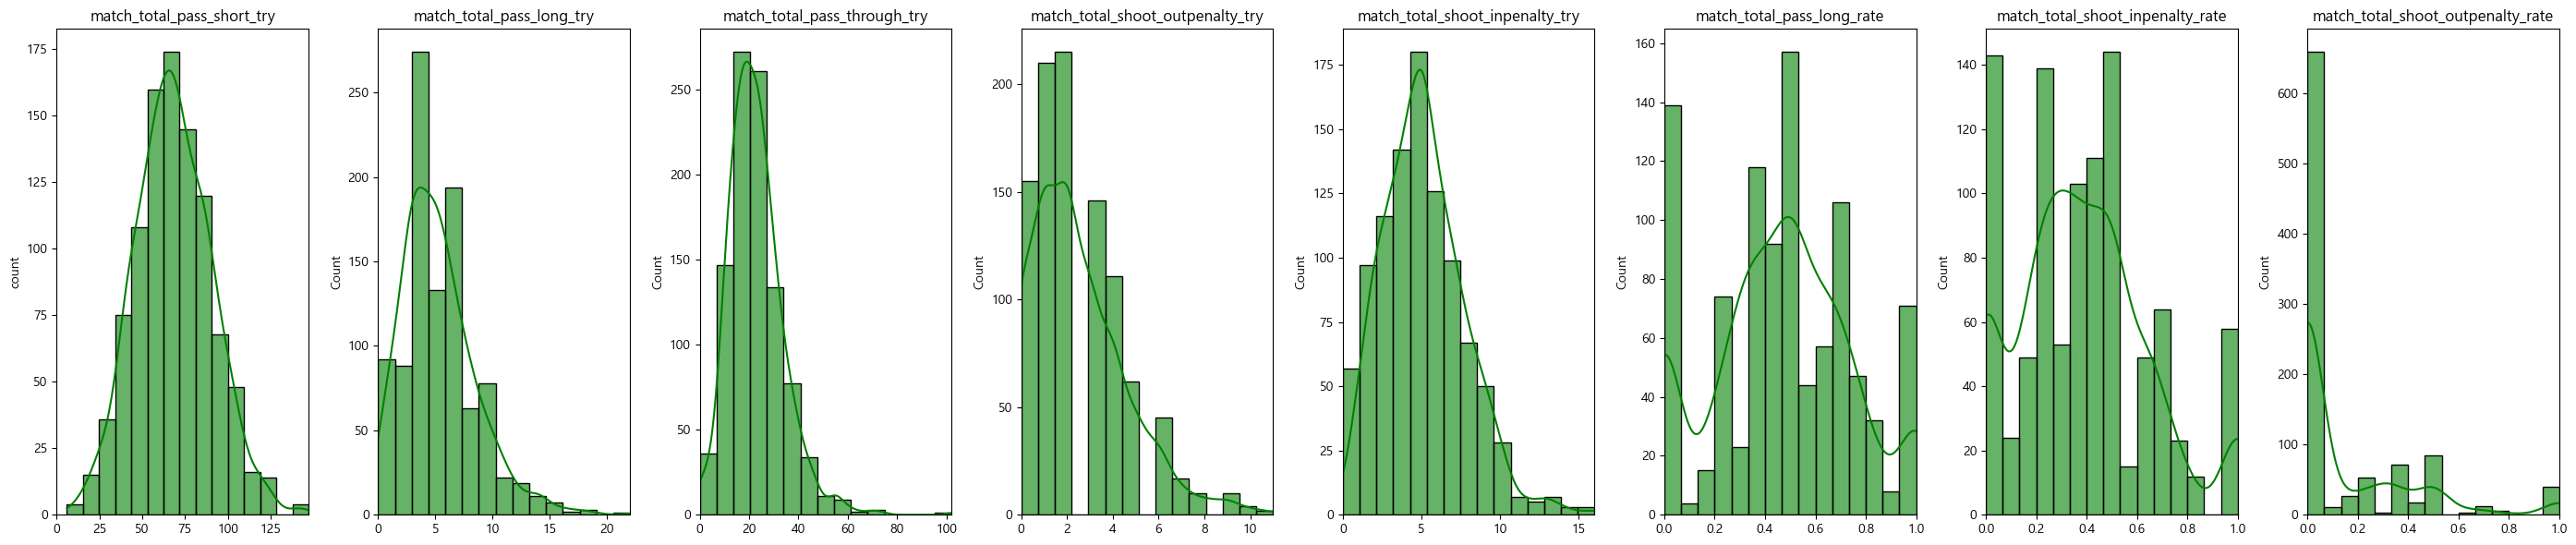

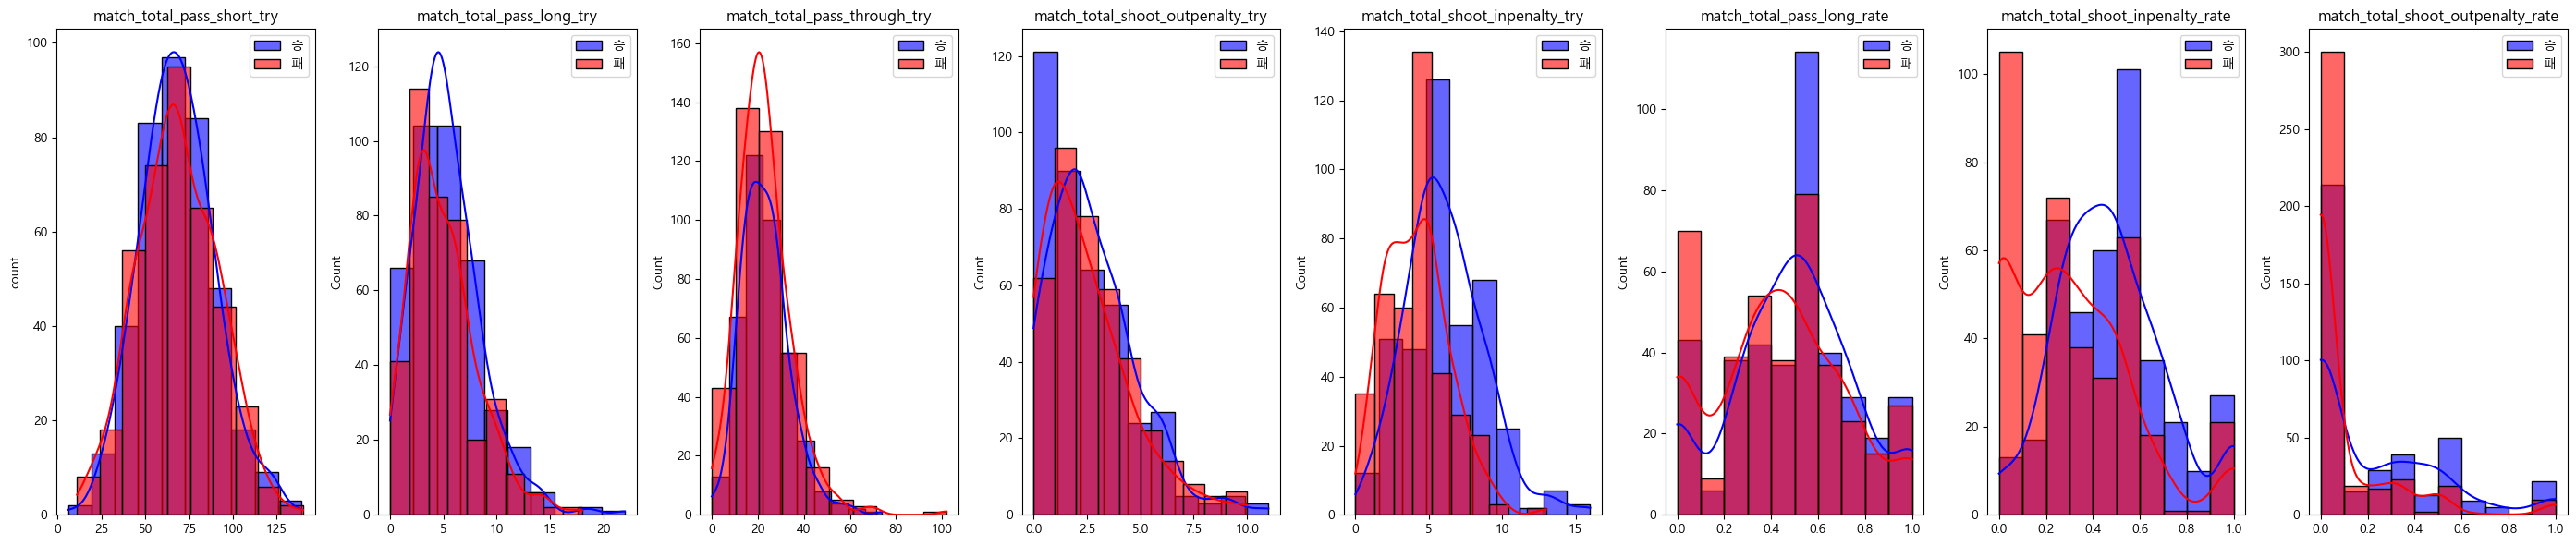

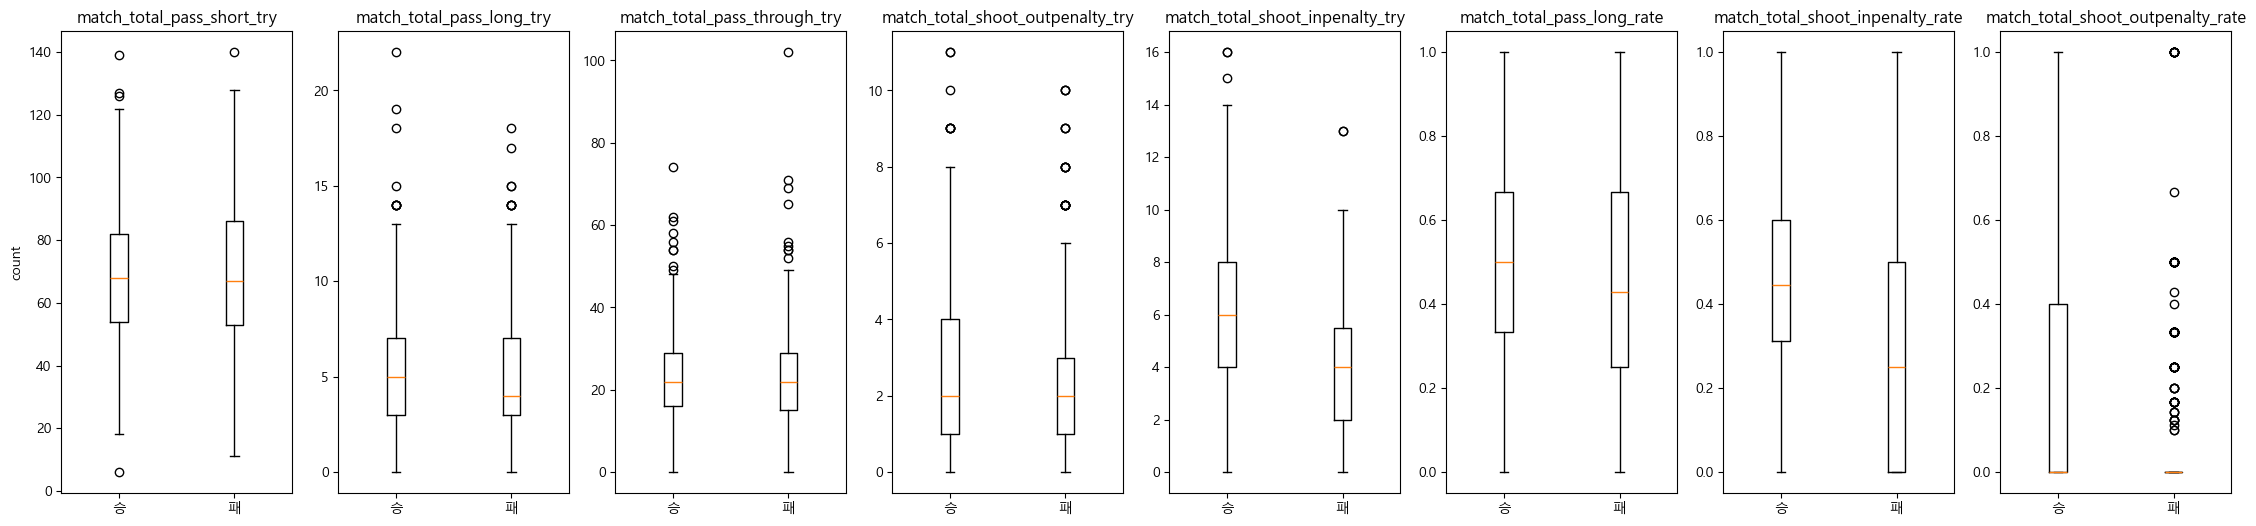

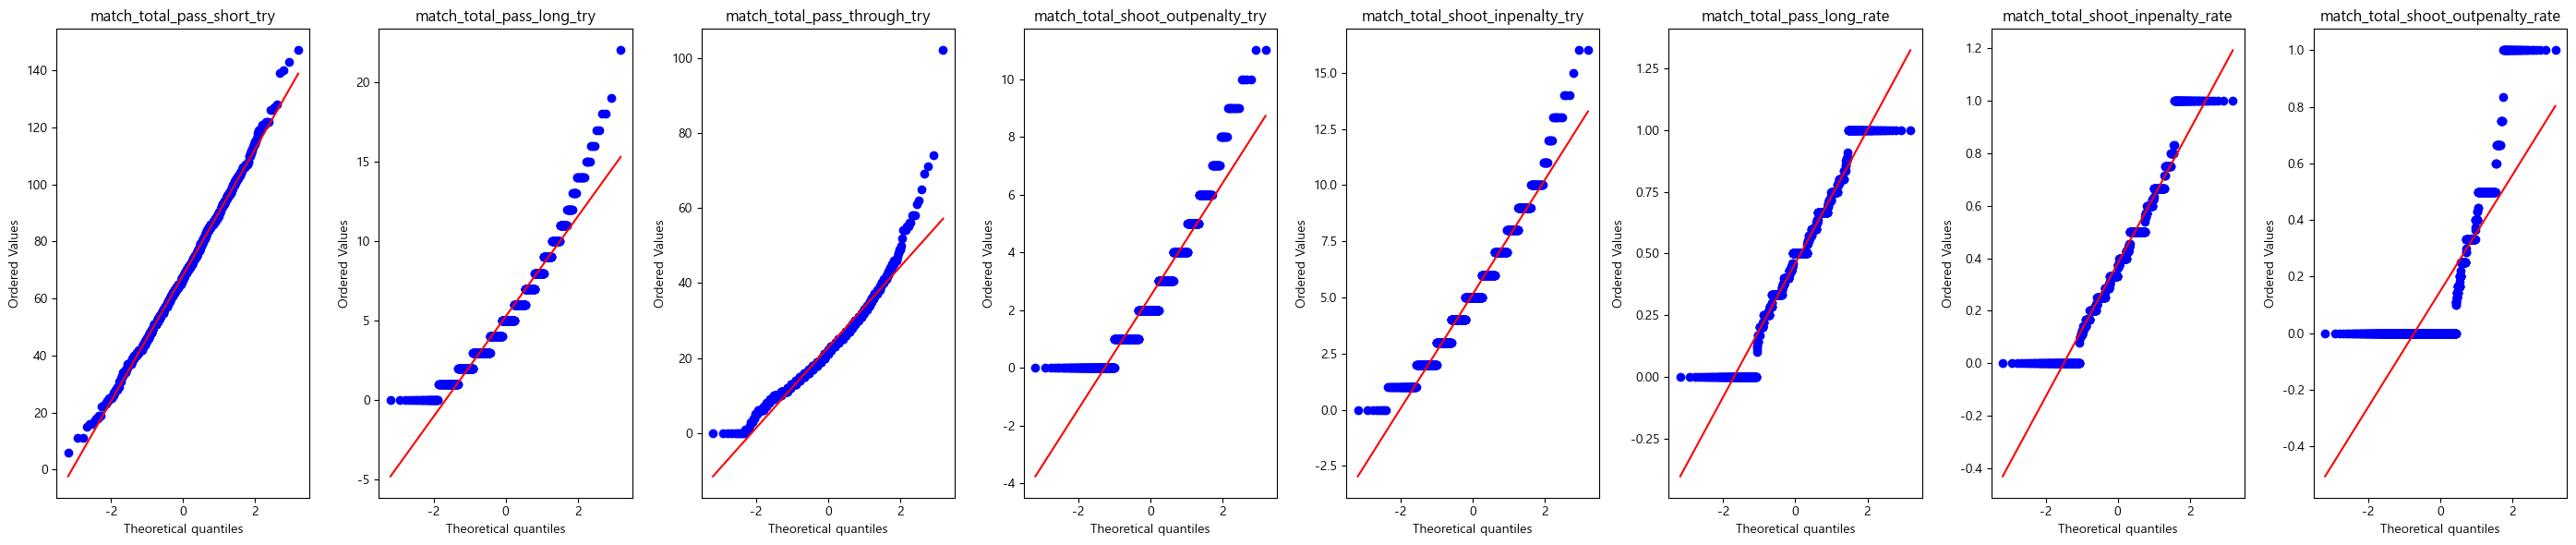

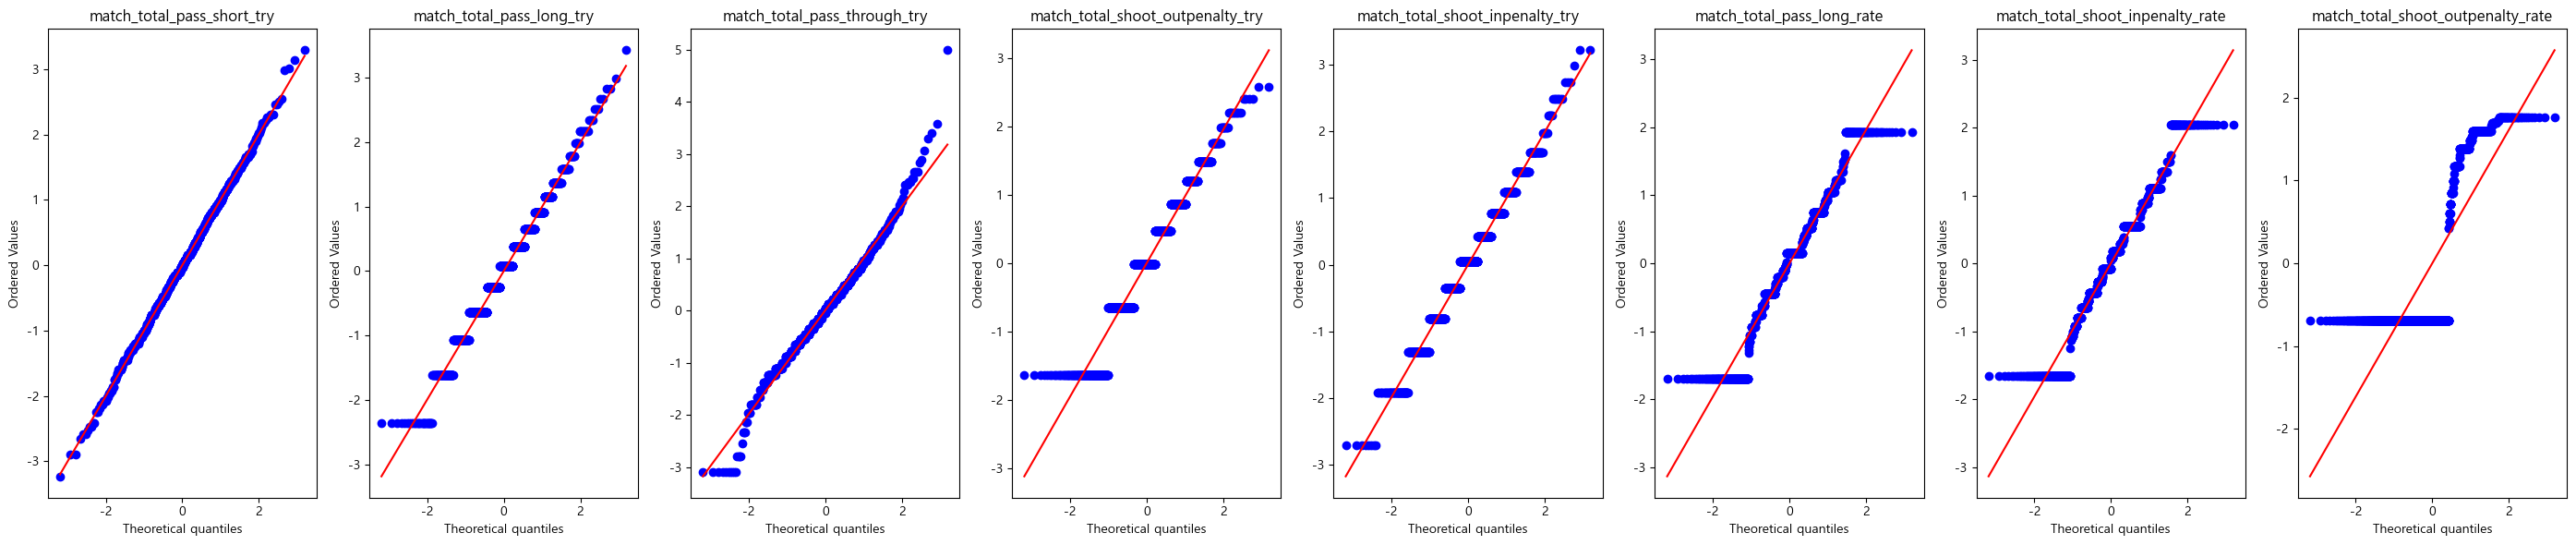

In [259]:
col_hist_all(df4_temp, df4_temp.columns);
col_hist(df4_win, df4_lose, df4_temp.columns);
col_boxplot(df4_win, df4_lose, df4_temp.columns);

col_qqplot_all(df4_temp, df4_temp.columns);
col_qqplot_norm_all(df4_temp_qq, df4_temp.columns);

In [260]:
normality_test(df4_temp, df4_win, df4_lose, df4_temp.columns)

-----------------------------------------------------
정규분포 O: 
 match_total_pass_short_try
-----------------------------------------------------
정규분포 X: 
 match_total_pass_long_try, match_total_pass_through_try, match_total_shoot_outpenalty_try, match_total_shoot_inpenalty_try, match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------
등분산성 O: 
 match_total_pass_short_try, match_total_pass_long_try, match_total_pass_through_try, match_total_shoot_outpenalty_try
-----------------------------------------------------
등분산성 X: 
 match_total_shoot_inpenalty_try, match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------


In [261]:
normality_test(df4_temp_qq, df4_win_temp_qq, df4_temp_lose_qq, df4_temp.columns)    

-----------------------------------------------------
정규분포 O: 
 match_total_pass_short_try
-----------------------------------------------------
정규분포 X: 
 match_total_pass_long_try, match_total_pass_through_try, match_total_shoot_outpenalty_try, match_total_shoot_inpenalty_try, match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------
등분산성 O: 
 match_total_pass_short_try, match_total_pass_long_try, match_total_pass_through_try, match_total_shoot_outpenalty_try
-----------------------------------------------------
등분산성 X: 
 match_total_shoot_inpenalty_try, match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------


In [262]:
group_difference_test(df4_win, df4_lose, df4_temp.columns)

-----------------------------------------------------
match_total_pass_short_try은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_pass_long_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_through_try은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_shoot_outpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_long_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_rate은(는) 승패에 따라 유의미한 차이가 있음


---

---

### Result

### 전체 Columns

In [263]:
df1.columns

Index(['match_id', 'user_ouid', 'user_nickname', 'match_result',
       'match_endtype', 'match_possession', 'match_avg_rating',
       'match_total_dribble', 'match_total_pass_try', 'match_total_shoot',
       'match_total_shoot_eff', 'match_total_goal', 'attack_position_ratings',
       'middle_position_ratings', 'defense_position_ratings',
       'goalkeeper_position_ratings', 'match_total_pass_short_try',
       'match_total_pass_long_try', 'match_total_pass_through_try',
       'match_total_shoot_outpenalty_try', 'match_total_shoot_inpenalty_try',
       'match_total_pass_rate', 'match_total_pass_short_rate',
       'match_total_pass_long_rate', 'match_total_pass_through_rate',
       'match_total_shoot_inpenalty_rate',
       'match_total_shoot_outpenalty_rate'],
      dtype='object')

### 1. VIF 계수 확인 및 다중공선성 제거
- VIF => threshold = 10
- CORR => threshold = 0.8

In [278]:
df2_temp.columns

Index(['match_total_pass_short_try', 'match_total_pass_long_try',
       'match_total_pass_through_try', 'match_total_shoot_outpenalty_try',
       'match_total_shoot_inpenalty_try', 'match_total_pass_long_rate',
       'match_total_shoot_inpenalty_rate',
       'match_total_shoot_outpenalty_rate'],
      dtype='object')

### 2. 변수별 정규성 및 등분산성 확인 
- 정규성 검정 => scipy.stats.shapiro, scipy.stats.kstest
- 승, 패에 따른 등분산성 검정 => scipy.stats.levene 

In [276]:
normality_test(df4_temp, df4_win, df4_lose, df4_temp.columns)


-----------------------------------------------------
정규분포 O: 
 match_total_pass_short_try
-----------------------------------------------------
정규분포 X: 
 match_total_pass_long_try, match_total_pass_through_try, match_total_shoot_outpenalty_try, match_total_shoot_inpenalty_try, match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------
등분산성 O: 
 match_total_pass_short_try, match_total_pass_long_try, match_total_pass_through_try, match_total_shoot_outpenalty_try
-----------------------------------------------------
등분산성 X: 
 match_total_shoot_inpenalty_try, match_total_pass_long_rate, match_total_shoot_inpenalty_rate, match_total_shoot_outpenalty_rate
-----------------------------------------------------


### 3. 변수별 승, 패에 따른 차이 확인
- 독립표본 t-test => scipy.stats.ttest_ind
- 비모수적 검정 Mann-Whitney U test ⇒ scipy.stats.mannwhitneyu

In [277]:
group_difference_test(df4_win, df4_lose, df4_temp.columns)

-----------------------------------------------------
match_total_pass_short_try은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_pass_long_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_through_try은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX
-----------------------------------------------------
match_total_shoot_outpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_long_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_rate은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_rate은(는) 승패에 따라 유의미한 차이가 있음
